<a href="https://colab.research.google.com/github/dsklnr/dsklnr/blob/main/ML_Assignment5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import to_hex
import seaborn as sns
import json
import logging
import re
from skimage import io
from skimage.color import rgb2gray
from sklearn import cluster, decomposition
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from statsmodels.multivariate.pca import PCA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from time import time

Load all the images in the first zip file. Use scikit-image (https://scikit-image.org/) to load the
images and convert them to grayscale (rgb2gray)

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
# Import cat face images
image_dir = '/content/drive/My Drive/dataset-part1'
cat_faces = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('.png'))]

# Convert the images to greyscale
images = [io.imread(file) for file in cat_faces]
gray_images = [rgb2gray(image) for image in images]

Adapt the code from the following website to work with the cat faces:

https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

Loading and preprocessing the Cat faces dataset.

In [68]:
rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# Shuffle the images and flatten them
faces = np.array([image.flatten() for image in gray_images])
faces, _ = shuffle(faces, np.zeros(faces.shape[0]), random_state=rng)
n_samples, n_features = faces.shape

# Global centering (centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (centering all features for each sample)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print(f"Dataset consists of {n_samples} faces")

Dataset consists of 410 faces


Define a base function to plot the gallery of faces.

In [69]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

Let’s take a look at our data. Gray color indicates negative values, white indicates positive values.

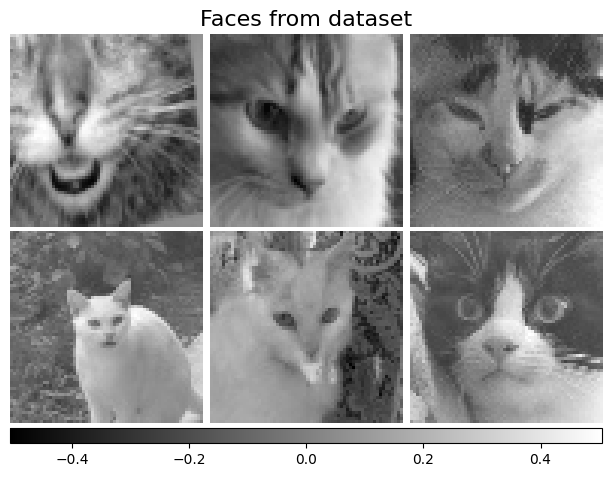

In [70]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

# Eigenfaces - PCA using randomized SVD

Linear dimensionality reduction using Singular Value Decomposition (SVD) of the data to project it to a lower dimensional space.

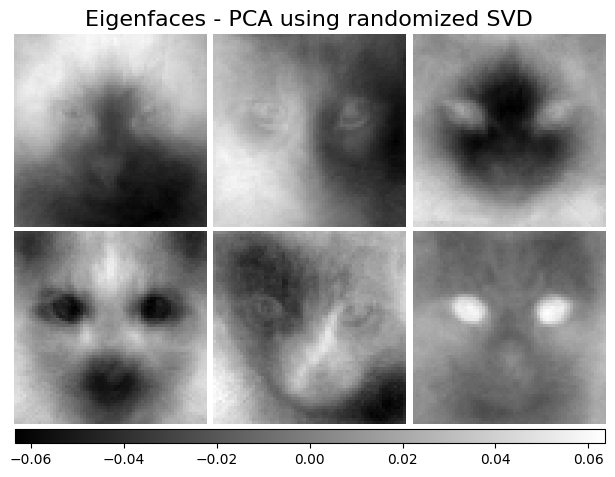

In [71]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

# Non-negative components - NM

Estimate non-negative original data as production of two non-negative matrices.

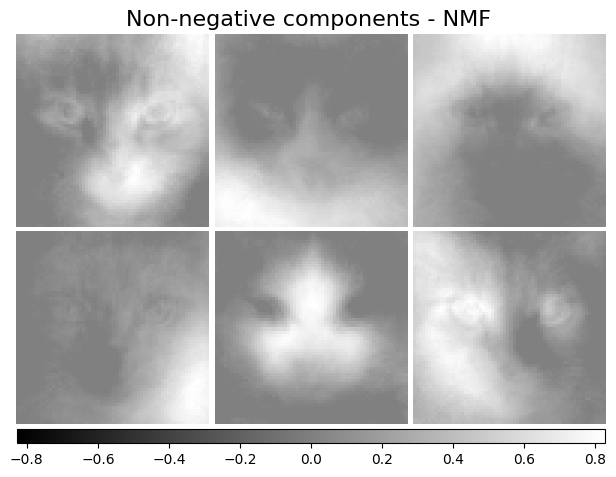

In [72]:
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

# Independent components - FastICA

Independent component analysis separates a multivariate vectors into additive subcomponents that are maximally independent.

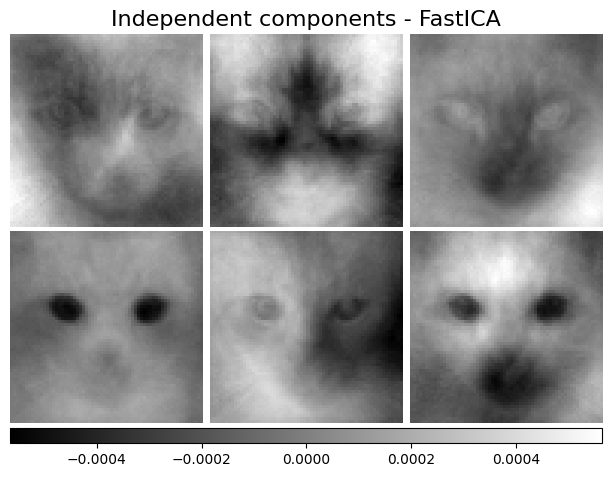

In [73]:
ica_estimator = decomposition.FastICA(
    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5
)
ica_estimator.fit(faces_centered)
plot_gallery(
    "Independent components - FastICA", ica_estimator.components_[:n_components]
)

# Sparse components - MiniBatchSparsePCA

Mini-batch sparse PCA (MiniBatchSparsePCA) extracts the set of sparse components that best reconstruct the data. This variant is faster but less accurate than the similar SparsePCA.

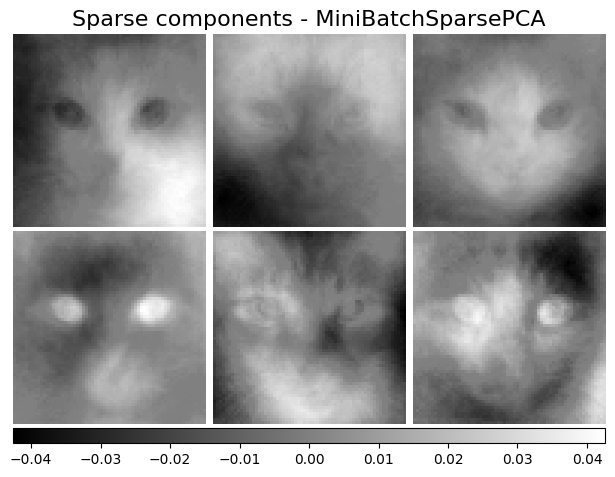

In [74]:
batch_pca_estimator = decomposition.MiniBatchSparsePCA(
    n_components=n_components, alpha=0.1, max_iter=100, batch_size=3, random_state=rng
)
batch_pca_estimator.fit(faces_centered)
plot_gallery(
    "Sparse components - MiniBatchSparsePCA",
    batch_pca_estimator.components_[:n_components],
)

# Dictionary Learning

By default, MiniBatchDictionaryLearning divides the data into mini-batches and optimizes in an online manner by cycling over the mini-batches for the specified number of iterations.

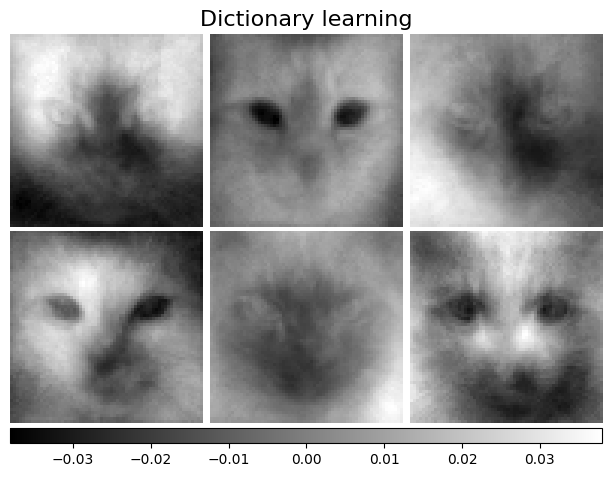

In [75]:
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

# Cluster centers - MiniBatchKMeans

sklearn.cluster.MiniBatchKMeans is computationally efficient and implements on-line learning with a partial_fit method. That is why it could be beneficial to enhance some time-consuming algorithms with MiniBatchKMeans.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


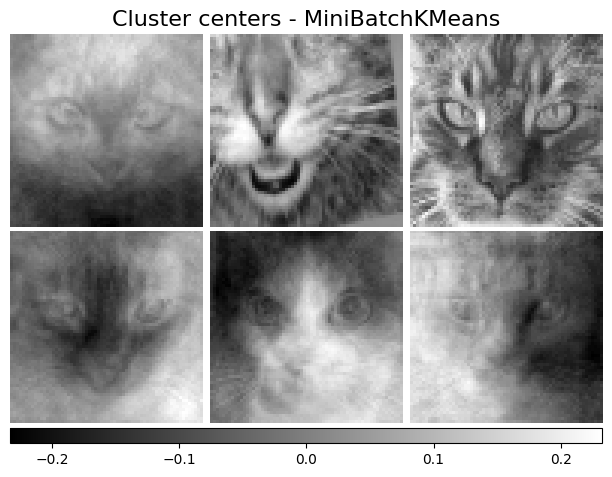

In [76]:
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=n_components,
    tol=1e-3,
    batch_size=20,
    max_iter=50,
    random_state=rng,
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

# Factor Analysis components - FA

FactorAnalysis is similar to PCA but has the advantage of modelling the variance in every direction of the input space independently (heteroscedastic noise). Read more in the User Guide.

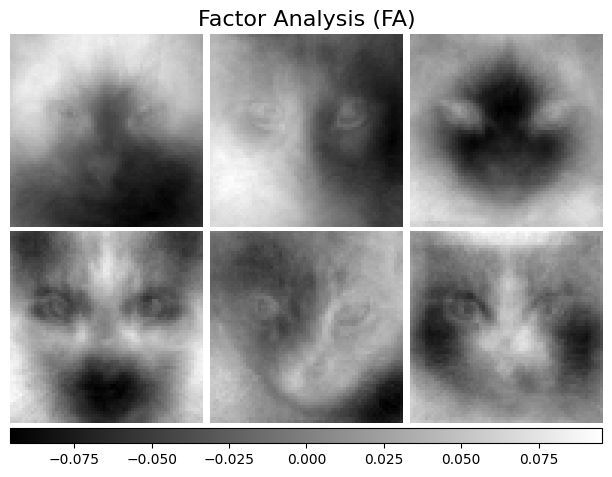

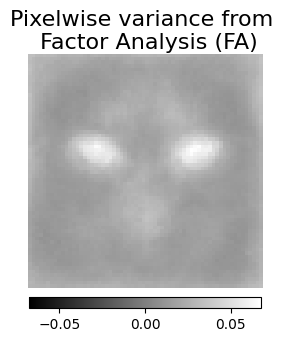

In [77]:
fa_estimator = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_estimator.fit(faces_centered)
plot_gallery("Factor Analysis (FA)", fa_estimator.components_[:n_components])

# --- Pixelwise variance
plt.figure(figsize=(3.2, 3.6), facecolor="white", tight_layout=True)
vec = fa_estimator.noise_variance_
vmax = max(vec.max(), -vec.min())
plt.imshow(
    vec.reshape(image_shape),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=-vmax,
    vmax=vmax,
)
plt.axis("off")
plt.title("Pixelwise variance from \n Factor Analysis (FA)", size=16, wrap=True)
plt.colorbar(orientation="horizontal", shrink=0.8, pad=0.03)
plt.show()

# Decomposition: Dictionary learning

In the further section, let’s consider Dictionary Learning more precisely. Dictionary learning is a problem that amounts to finding a sparse representation of the input data as a combination of simple elements. These simple elements form a dictionary. It is possible to constrain the dictionary and/or coding coefficients to be positive to match constraints that may be present in the data.

MiniBatchDictionaryLearning implements a faster, but less accurate version of the dictionary learning algorithm that is better suited for large datasets. Read more in the User Guide.

Plot the same samples from our dataset but with another colormap. Red indicates negative values, blue indicates positive values, and white represents zeros.

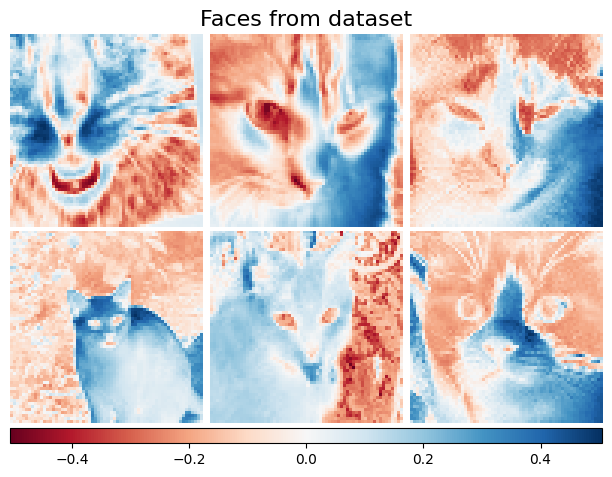

In [78]:
plot_gallery("Faces from dataset", faces_centered[:n_components], cmap=plt.cm.RdBu)

# Dictionary learning - positive dictionary

In the following section we enforce positivity when finding the dictionary

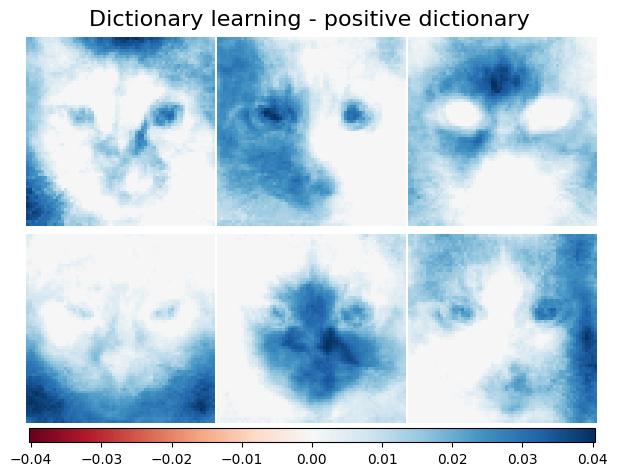

In [79]:
dict_pos_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    random_state=rng,
    positive_dict=True,
)
dict_pos_dict_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary",
    dict_pos_dict_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Dictionary learning - positive code

Below we constrain the coding coefficients as a positive matrix

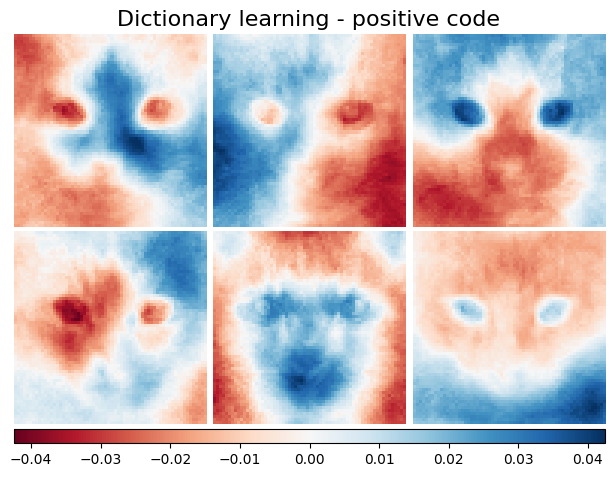

In [80]:
dict_pos_code_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_code=True,
)
dict_pos_code_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive code",
    dict_pos_code_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Dictionary learning - positive dictionary & code

Also below are the results if the dictionary values and coding coefficients are positively constrained

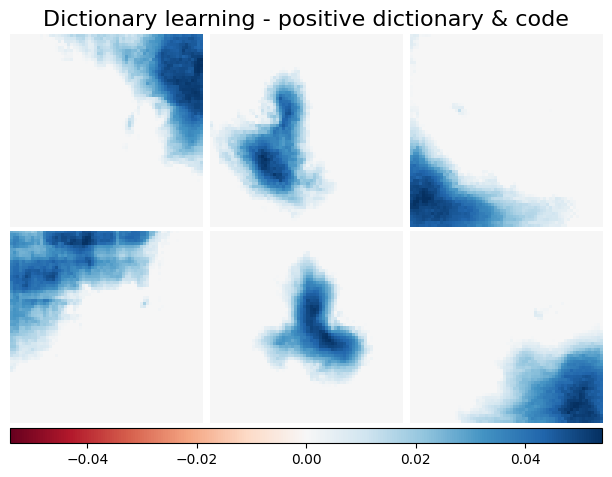

In [81]:
dict_pos_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_dict=True,
    positive_code=True,
)
dict_pos_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary & code",
    dict_pos_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

# Selecting the number of components

Next, you will work on selecting the number of components. You may have seen a plot before
using the eigenvalues. Recreate this plot for the cat dataset: you can get them from the PCA
model object. However, you have another method to select the number of components, now
that you can use cross-validation.

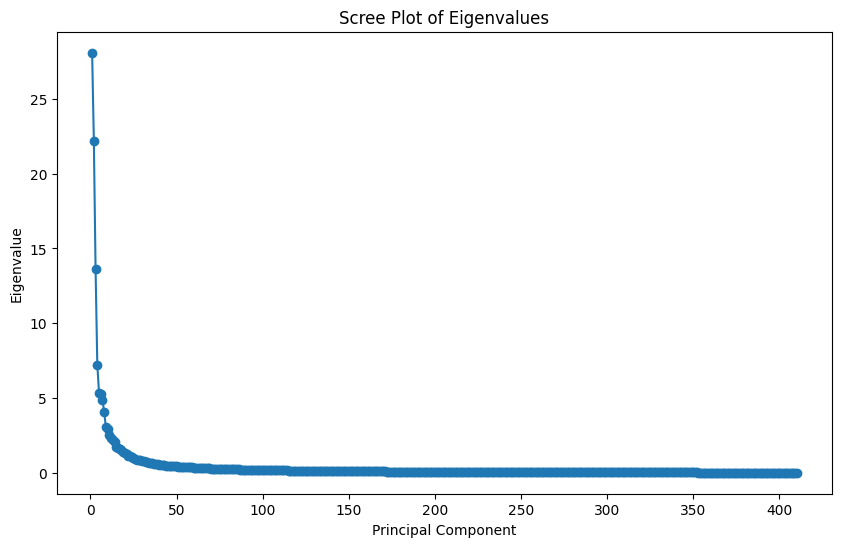

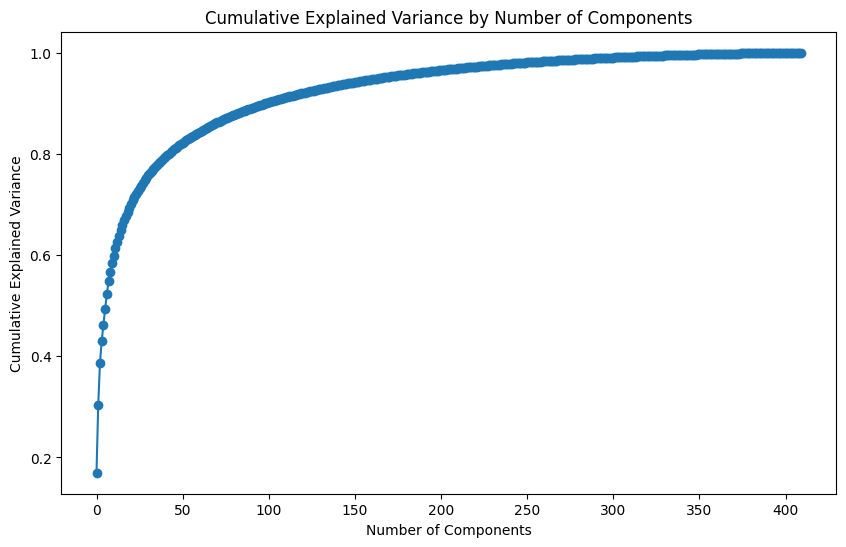

In [84]:
# Shuffle the images
rng = np.random.RandomState(0)
faces, _ = shuffle(faces, np.zeros(faces.shape[0]), random_state=rng)
n_samples, n_features = faces.shape

# Global centering (centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (centering all features for each sample)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

# Perform PCA and plot eigenvalues
pca = PCA()
pca.fit(faces_centered)

# Plot the eigenvalues (variance explained by each principal component)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot of Eigenvalues')
plt.show()

# Explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.show()

In [90]:
# Use cross-validation to select the number of components based on reconstruction error
kf = KFold(n_splits=5)
components_range = range(1, 328)
reconstruction_errors = []

for n_components in components_range:
    pca = PCA(n_components=n_components)
    fold_errors = []

    for train_index, test_index in kf.split(faces_centered):
        X_train, X_test = faces_centered[train_index], faces_centered[test_index]
        pca.fit(X_train)
        X_reduced = pca.transform(X_test)
        X_reconstructed = pca.inverse_transform(X_reduced)
        fold_errors.append(mean_squared_error(X_test, X_reconstructed))

    reconstruction_errors.append(np.mean(fold_errors))

In [91]:
# Optimal number of components based on reconstruction error
optimal_components = components_range[np.argmin(reconstruction_errors)]
print(f"Optimal number of components: {optimal_components}")

Optimal number of components: 327


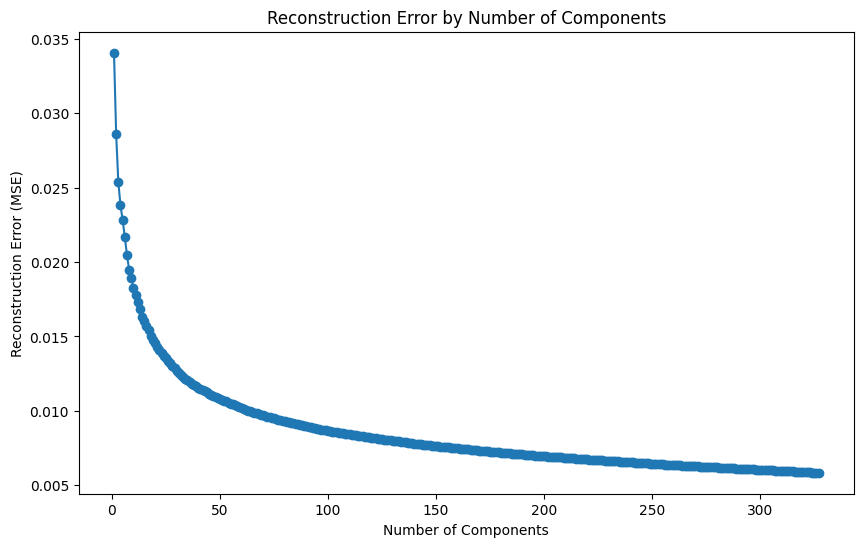

In [92]:
# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(components_range, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error by Number of Components')
plt.show()

## Clothing Reviews with Unsupervised Learning

Next, you will revisit our clothing reviews dataset. Load the JSON data from modcloth as you did in assignment module 4.

In [52]:
# Import modcloth_final_data.json
os.chdir('/content/drive/My Drive/')

data_list = []
with open('modcloth_final_data.json', 'r') as file:
    for line in file:
        try:
            data_list.append(json.loads(line))
        except json.JSONDecodeError:
            print("Warning: Skipping invalid JSON line.")

In [53]:
# Convert the list into a DataFrame
modcloth_data = pd.DataFrame(data_list)
modcloth_data.head()

item_id waist  size  quality cup size hips bra size category bust   height  \
0  123373    29     7      5.0        d   38       34      new   36  5ft 6in   
1  123373    31    13      3.0        b   30       36      new  NaN  5ft 2in   
2  123373    30     7      2.0        b  NaN       32      new  NaN  5ft 7in   
3  123373   NaN    21      5.0     dd/e  NaN      NaN      new  NaN      NaN   
4  123373   NaN    18      5.0        b  NaN       36      new  NaN  5ft 2in   

          user_name         length    fit user_id shoe size shoe width  \
0             Emily     just right  small  991571       NaN        NaN   
1  sydneybraden2001     just right  small  587883       NaN        NaN   
2             Ugggh  slightly long  small  395665      9.00        NaN   
3      alexmeyer626     just right    fit  875643       NaN        NaN   
4        dberrones1  slightly long  small  944840       NaN        NaN   

  review_summary review_text  
0            NaN         NaN  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4            NaN         NaN

Use OrdinalEncoder to transform the categorical data to numerical
values. Combine the categorical and numerical data into a single data frame

In [54]:
# Identify categorical columns
categorical_columns = ['cup size', 'category', 'length', 'shoe width', 'waist',
                       'size', 'hips', 'bra size', 'shoe size']

# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(modcloth_data[categorical_columns])

# Create a DataFrame for the encoded categorical columns
encoded_df = pd.DataFrame(encoded_data, columns=categorical_columns)
encoded_df.head()

cup size  category  length  shoe width  waist  size  hips  bra size  \
0       4.0       2.0     0.0         NaN    9.0   7.0  16.0       3.0   
1       2.0       2.0     0.0         NaN   11.0  13.0   0.0       4.0   
2       2.0       2.0     1.0         NaN   10.0   7.0   NaN       2.0   
3       5.0       2.0     0.0         NaN    NaN  19.0   NaN       NaN   
4       2.0       2.0     1.0         NaN    NaN  17.0   NaN       4.0   

   shoe size  
0        NaN  
1        NaN  
2       13.0  
3        NaN  
4        NaN

In [55]:
# Get waist, size, hips, bra size, and shoe size columns
variables = ['height', 'bust']

# Convert variables to numeric values and store in a dataframe
numeric_df = modcloth_data[variables].apply(pd.to_numeric, errors='coerce')

In [56]:
# Convert the list into a DataFrame
modcloth_data = pd.DataFrame(data_list)

# Combined function to process height and bust
def convert_height_and_bust(row):
    # Convert height
    height_str = row['height']
    if isinstance(height_str, str):
        match = re.match(r"(\d+)ft (\d+)in", height_str)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2))
            row['height'] = feet * 12 + inches
        else:
            row['height'] = None
    else:
        row['height'] = None

    # Convert bust
    bust_str = row['bust']
    if isinstance(bust_str, str):
        match = re.match(r"(\d+)", bust_str)
        if match:
            row['bust'] = int(match.group(1))
        else:
            row['bust'] = None
    else:
        row['bust'] = None

    return row

# Apply the combined function to each row of the DataFrame
modcloth_data = modcloth_data.apply(convert_height_and_bust, axis=1)

# Convert height and bust to numeric and add them to the numeric_data DataFrame
numeric_df['height'] = modcloth_data['height'].apply(pd.to_numeric, errors='coerce')
numeric_df['bust'] = modcloth_data['bust'].apply(pd.to_numeric, errors='coerce')
numeric_df.head()

height  bust
0    66.0  36.0
1    62.0   NaN
2    67.0   NaN
3     NaN   NaN
4    62.0   NaN

In [57]:
# Combine the encoded categorical columns with the numerical columns
final_df = pd.concat([encoded_df, numeric_df], axis=1)
final_df.head()

cup size  category  length  shoe width  waist  size  hips  bra size  \
0       4.0       2.0     0.0         NaN    9.0   7.0  16.0       3.0   
1       2.0       2.0     0.0         NaN   11.0  13.0   0.0       4.0   
2       2.0       2.0     1.0         NaN   10.0   7.0   NaN       2.0   
3       5.0       2.0     0.0         NaN    NaN  19.0   NaN       NaN   
4       2.0       2.0     1.0         NaN    NaN  17.0   NaN       4.0   

   shoe size  height  bust  
0        NaN    66.0  36.0  
1        NaN    62.0   NaN  
2       13.0    67.0   NaN  
3        NaN     NaN   NaN  
4        NaN    62.0   NaN

In [32]:
# Perform PCA using statsmodels
pc = PCA(final_df, ncomp=2, method='nipals', missing='fill-em')

Use seaborn’s scatterplot to plot the first two principal components. Check the statsmodels
documentation for information on how to access the principal components from the pc object

<ipython-input-41-d86b0c32d623>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  principal_components['quality'] = modcloth_data['quality']


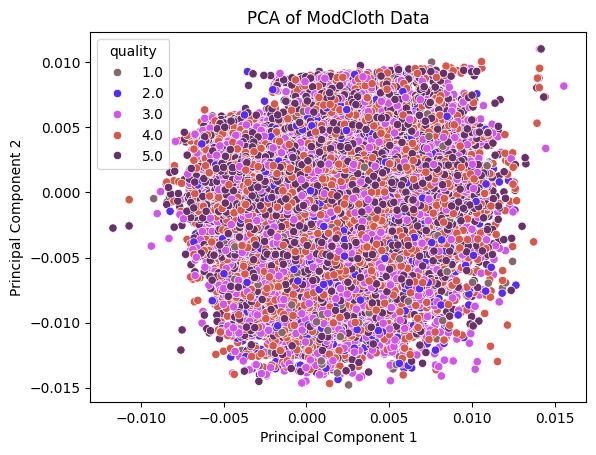

In [41]:
# Access the first two principal components
principal_components = pc.factors.iloc[:, :2]

# Add component names for clarity
principal_components.columns = ['PC1', 'PC2']

# Add the original quality rating labels back to the principal components DataFrame
principal_components['quality'] = modcloth_data['quality']

# Get the unique quality ratings
unique_qualities = principal_components['quality'].unique()

# Generate random colors for each unique quality rating
random_colors = {quality: to_hex(np.random.rand(3,)) for quality in unique_qualities}

# Plot the first two principal components using seaborn, coloring by quality rating with random colors
sns.scatterplot(x='PC1', y='PC2', hue='quality', palette=random_colors, data=principal_components)
plt.title('PCA of ModCloth Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

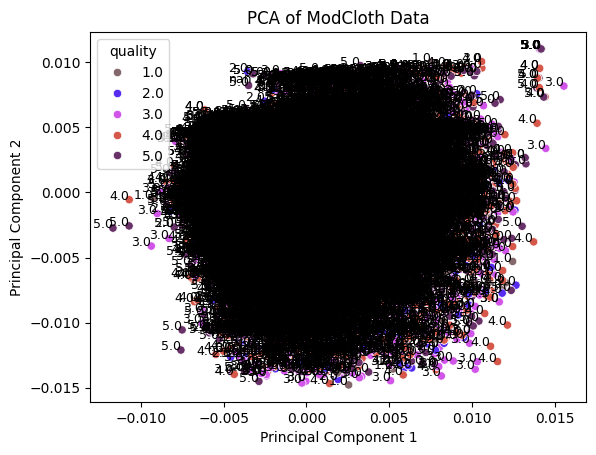

In [66]:
# Plot the first two principal components using seaborn, coloring by quality rating with random colors
sns.scatterplot(x='PC1', y='PC2', hue='quality', palette=random_colors, data=principal_components)

# Add labels to the points
for i in range(principal_components.shape[0]):
    plt.text(principal_components['PC1'][i], principal_components['PC2'][i],
             str(principal_components['quality'][i]),
             fontsize=9, ha='right')

plt.title('PCA of ModCloth Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Bag of Words

You should have code from assignment module 3 to extract the bag of words features you will
need, which you can then pass to the LDA object.

In [43]:
# Remove outliers: filter out records with no text data (NaNs)
filtered_reviews = modcloth_data.dropna(subset=['review_text', 'quality'])

# Create a variable that holdsa review text
corpus = filtered_reviews['review_text'].tolist()

# Display the first 5 items in the list
corpus[:5]

['I liked the color, the silhouette, and the fabric of this dress. But the ruching just looked bunchy and ruined the whole thing. I was so disappointed, I really waned to like this dress. Runs a little small; I would need to size up to make it workappropriate.',
 "From the other reviews it seems like this dress either works for your body type or it doesn't. I have a small waist but flabby tummy and this dress is perfect for me! The detail around the front hides everything and the clingyness of the dress makes me look curvier than usual. The material is thick but clings to your bum (enough that when you walk the bum jiggle shows through!) and the slit is a bit high so it's not necessarily office appropriate without tights, but it's a good dress with tights or for an occasion.",
 "I love the design and fit of this dress!  I wore it to a wedding and was comfortable all evening. The color is really pretty in person too!  The fabric quality seems decent but not great so I'm not sure how man

# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying NMF and LatentDirichletAllocation on a corpus of documents and extract additive models of the topic structure of the corpus. The output is a plot of topics, each represented as bar plot using top few words based on weights.

Non-negative Matrix Factorization is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make the example runnable in a couple of tens of seconds. You can try to increase the dimensions of the problem, but be aware that the time complexity is polynomial in NMF. In LDA, the time complexity is proportional to (n_samples * iterations).

Extracting tf-idf features for NMF...
done in 4.570s.
Extracting tf features for LDA...
done in 7.002s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 8.875s.


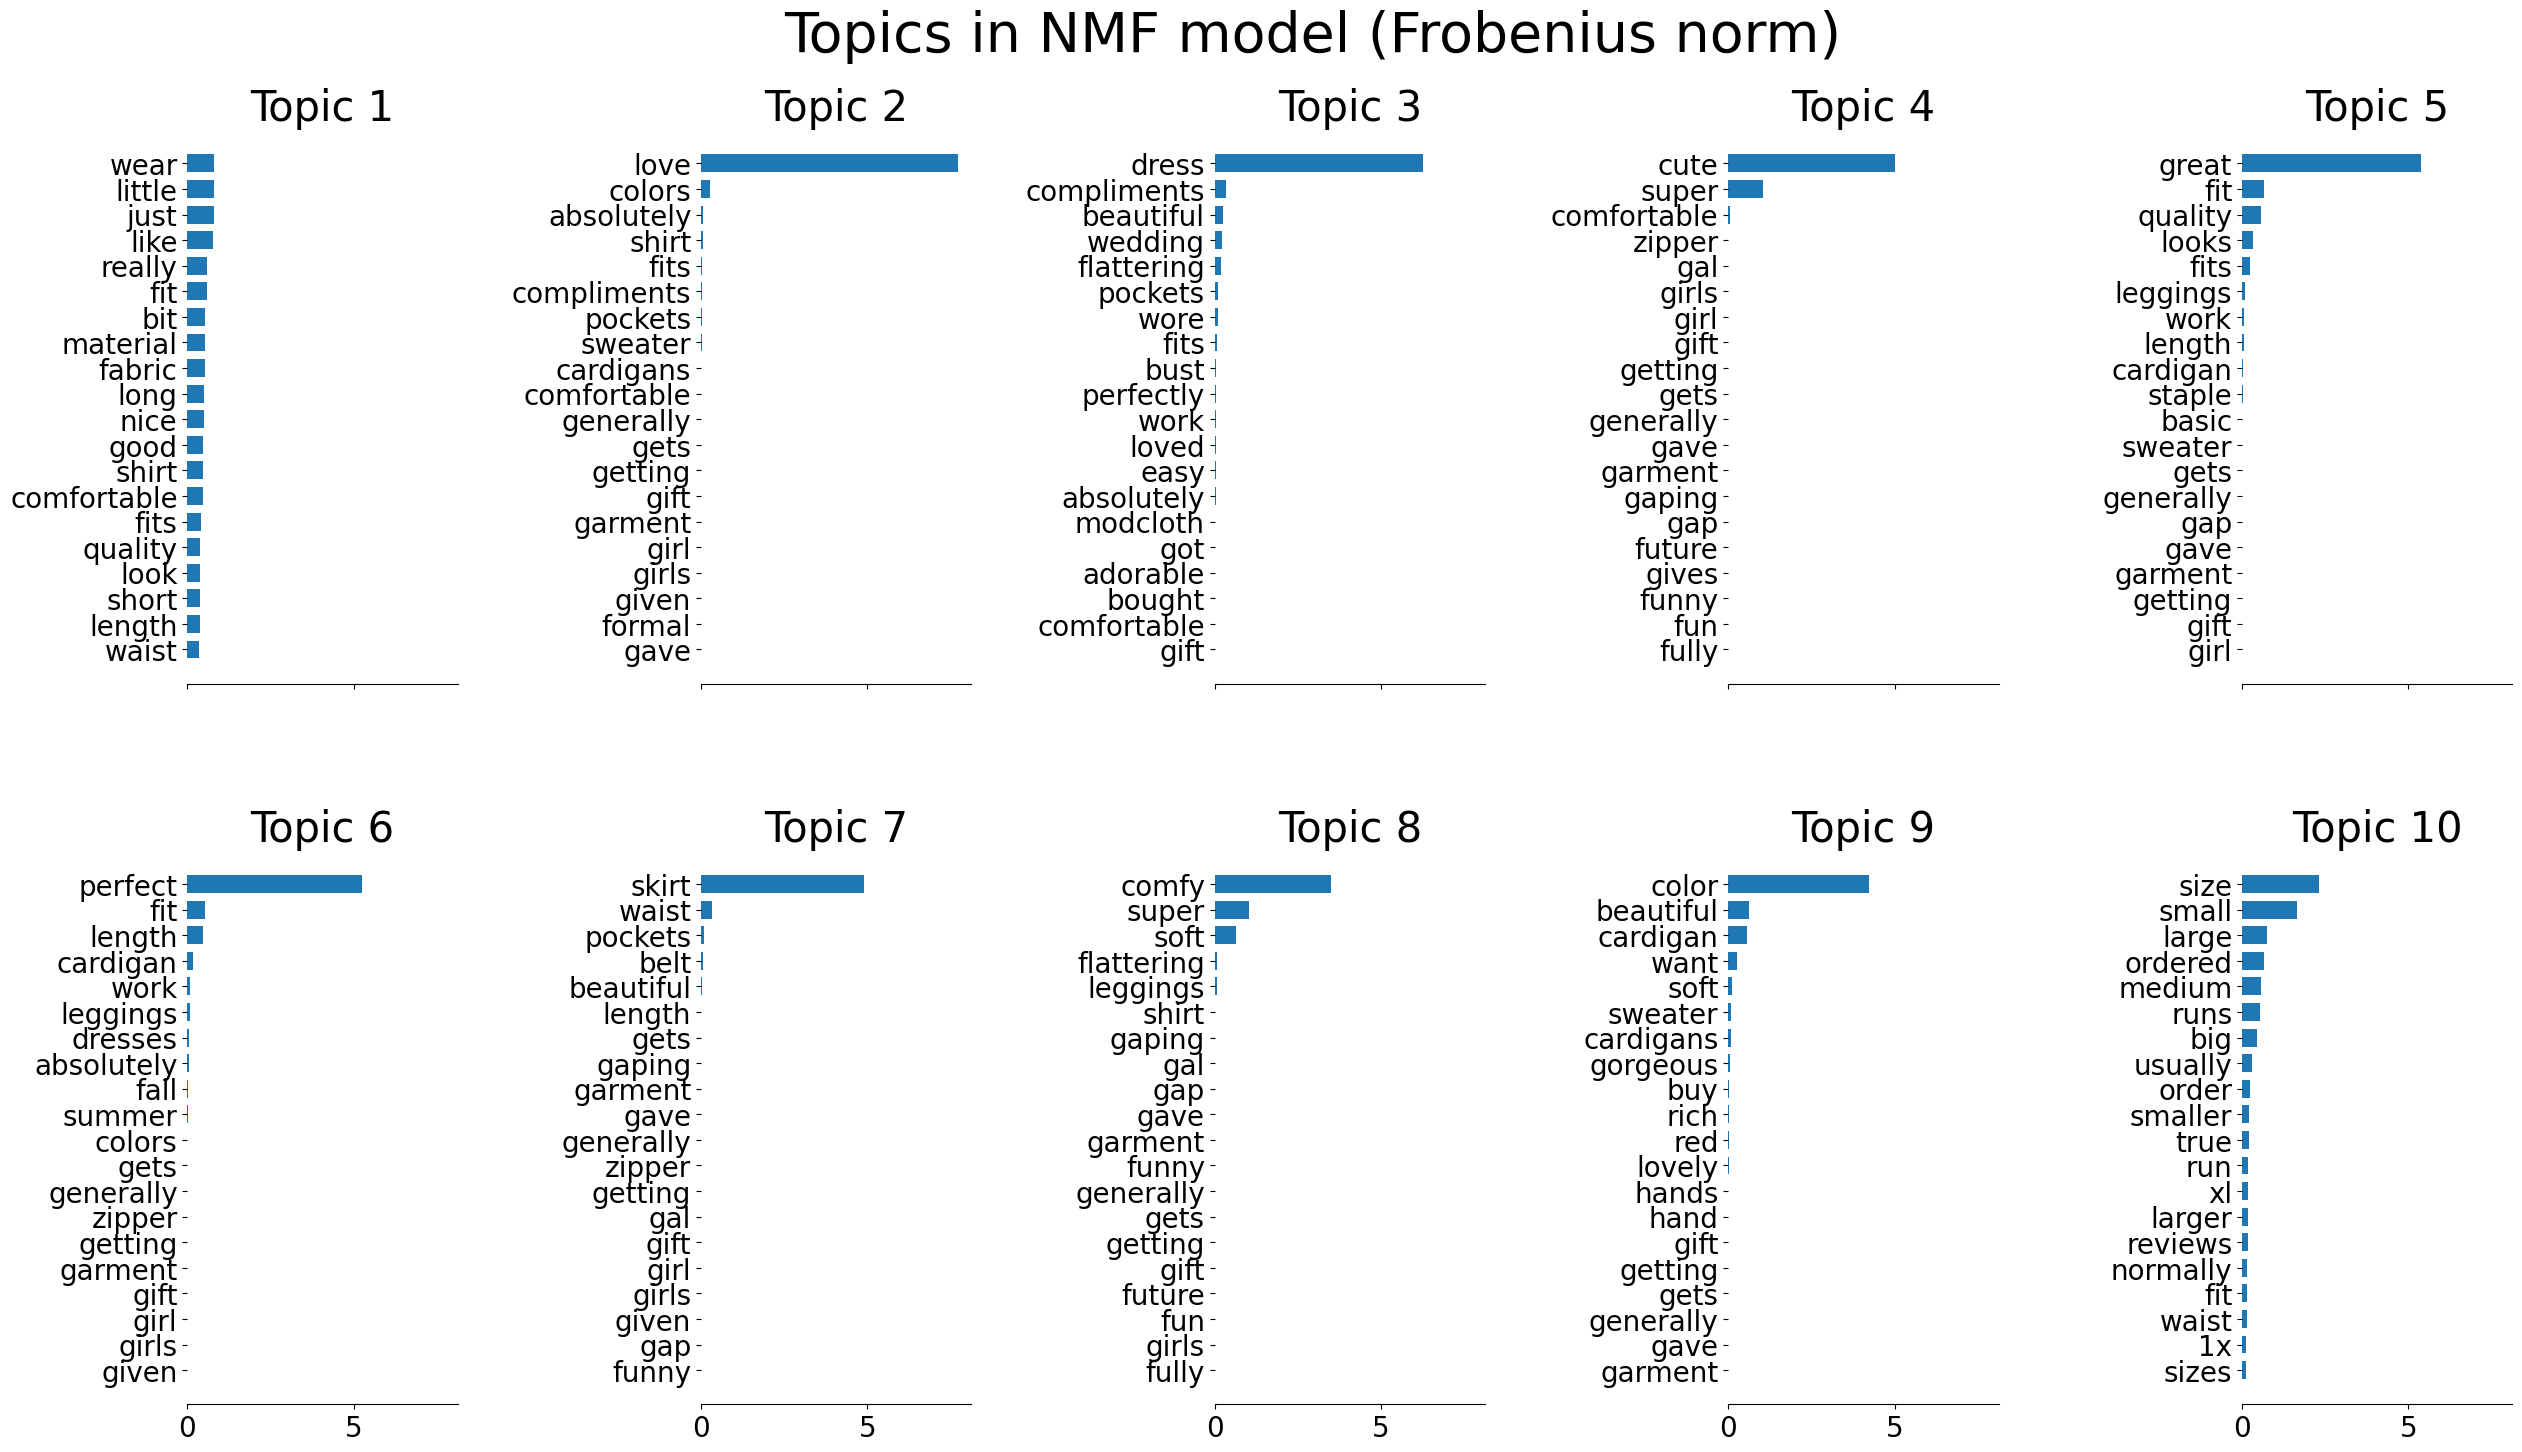



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 61.767s.


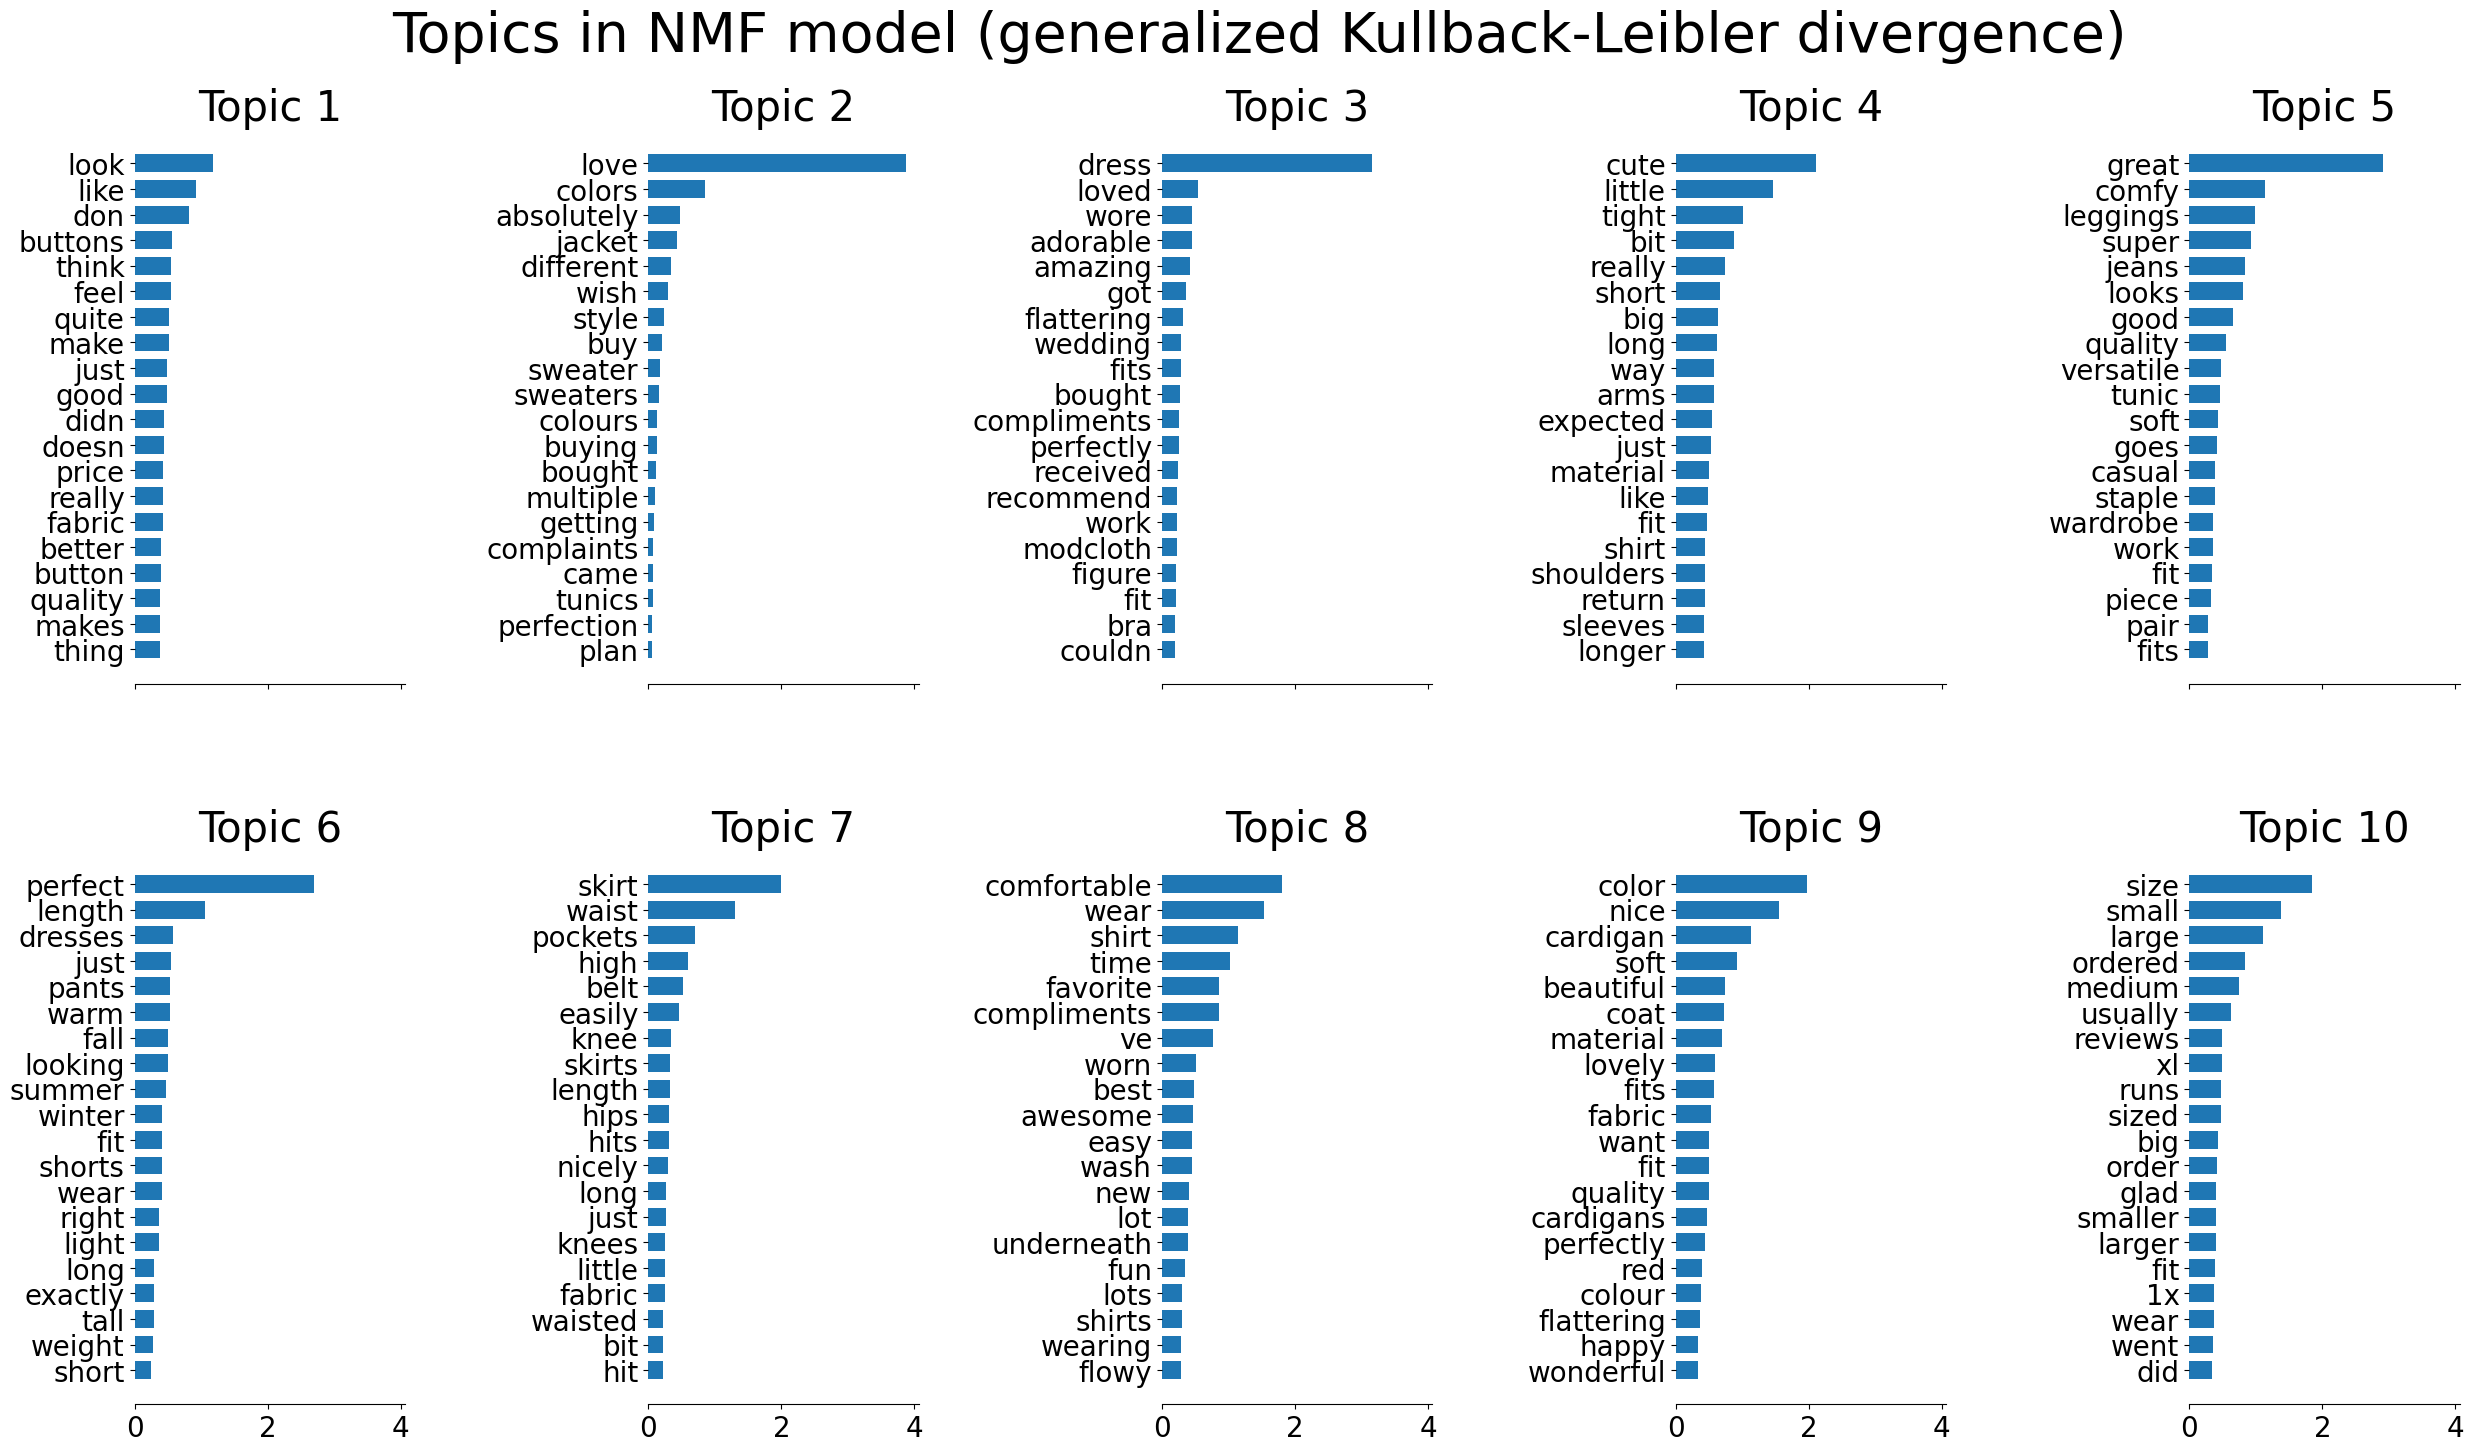



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 1.443s.


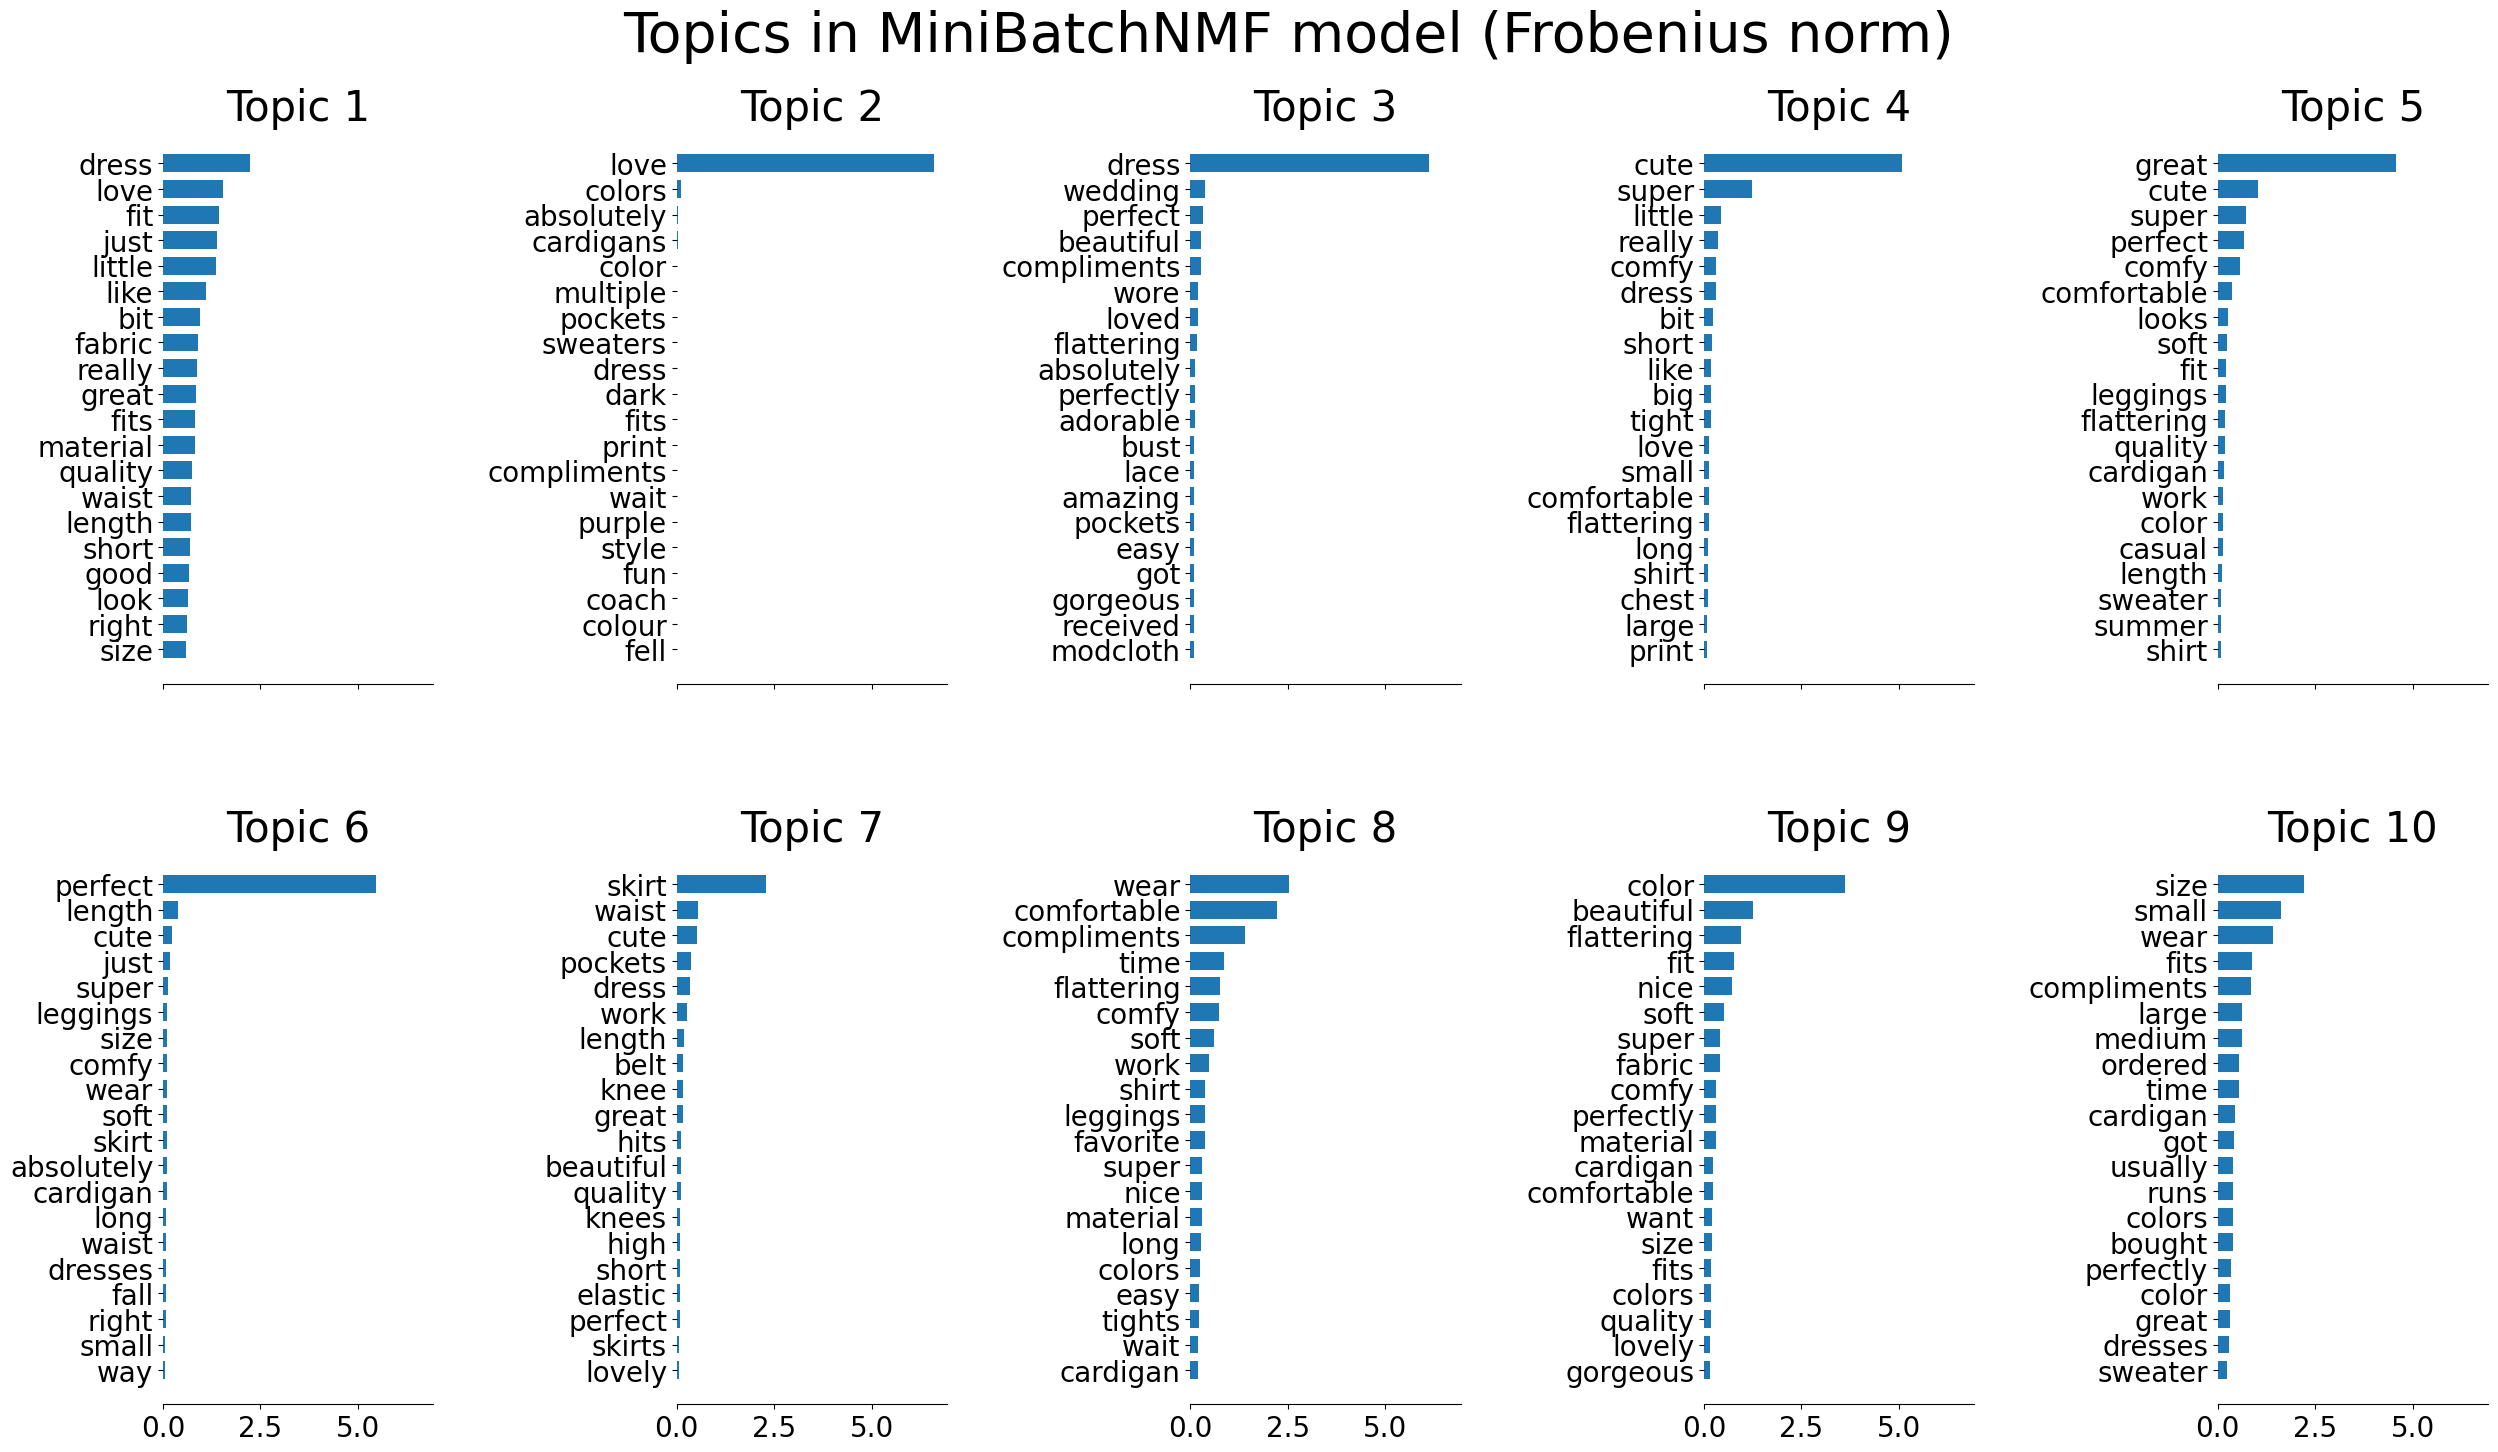



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 1.426s.


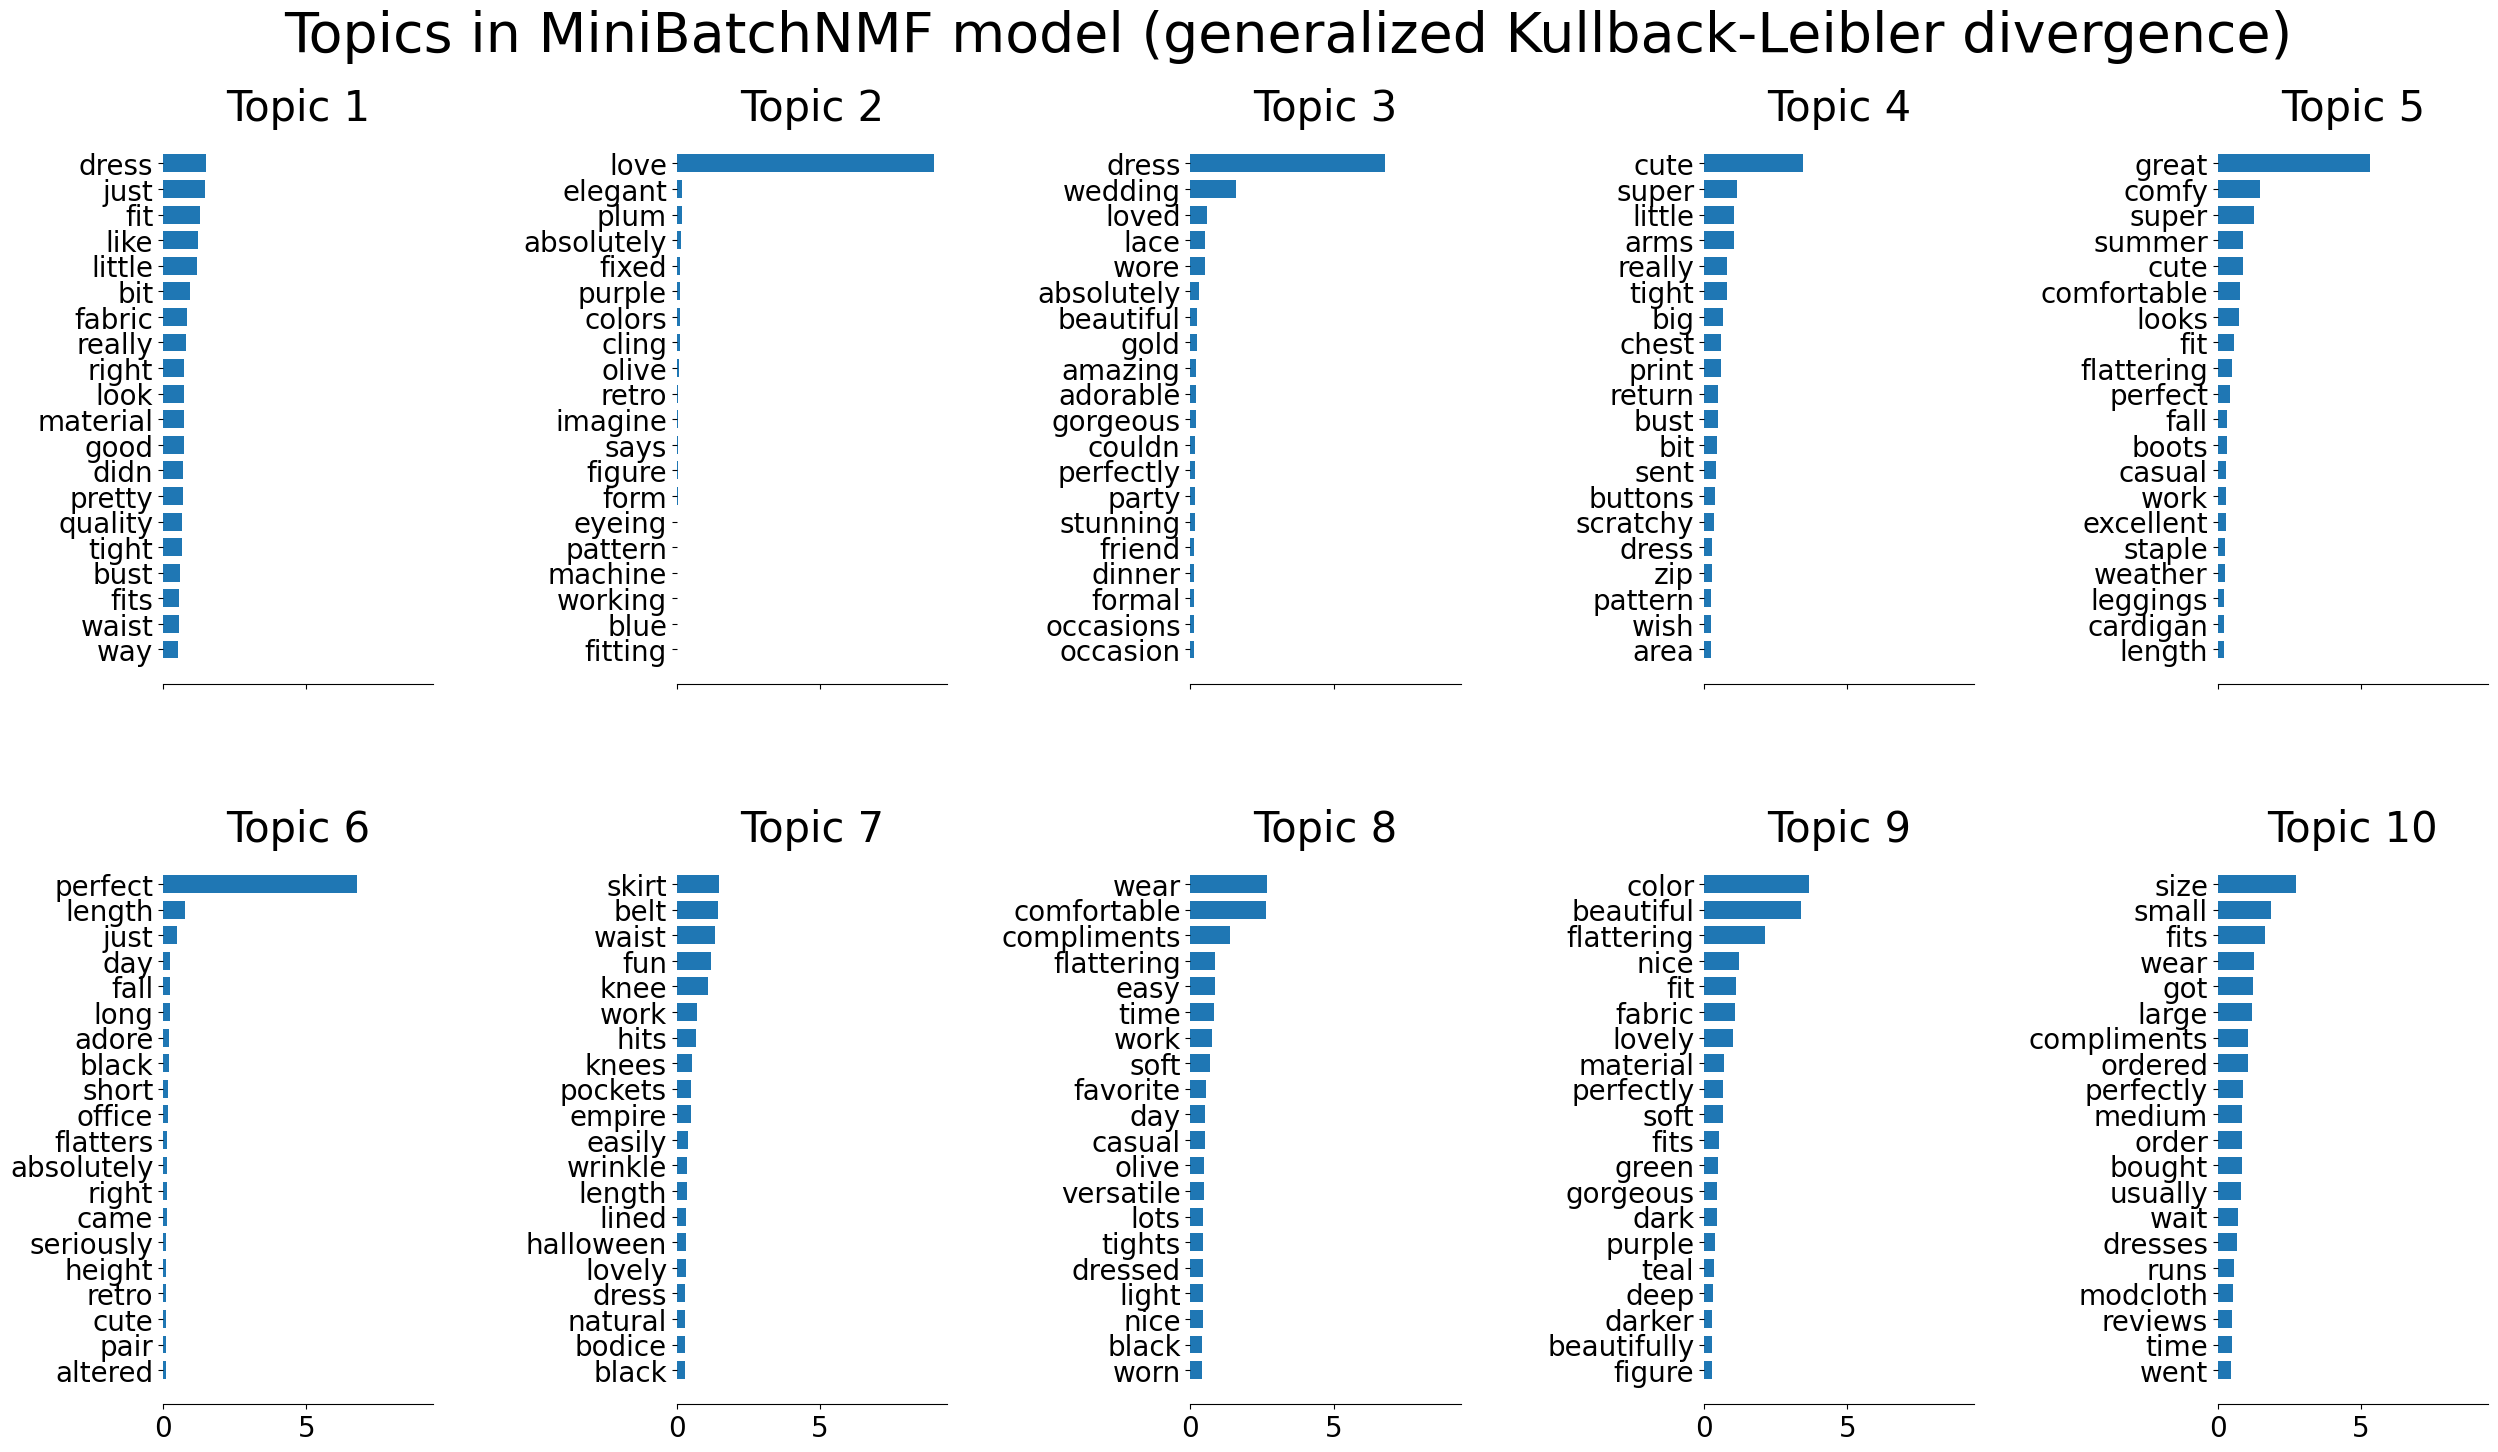



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 92.650s.


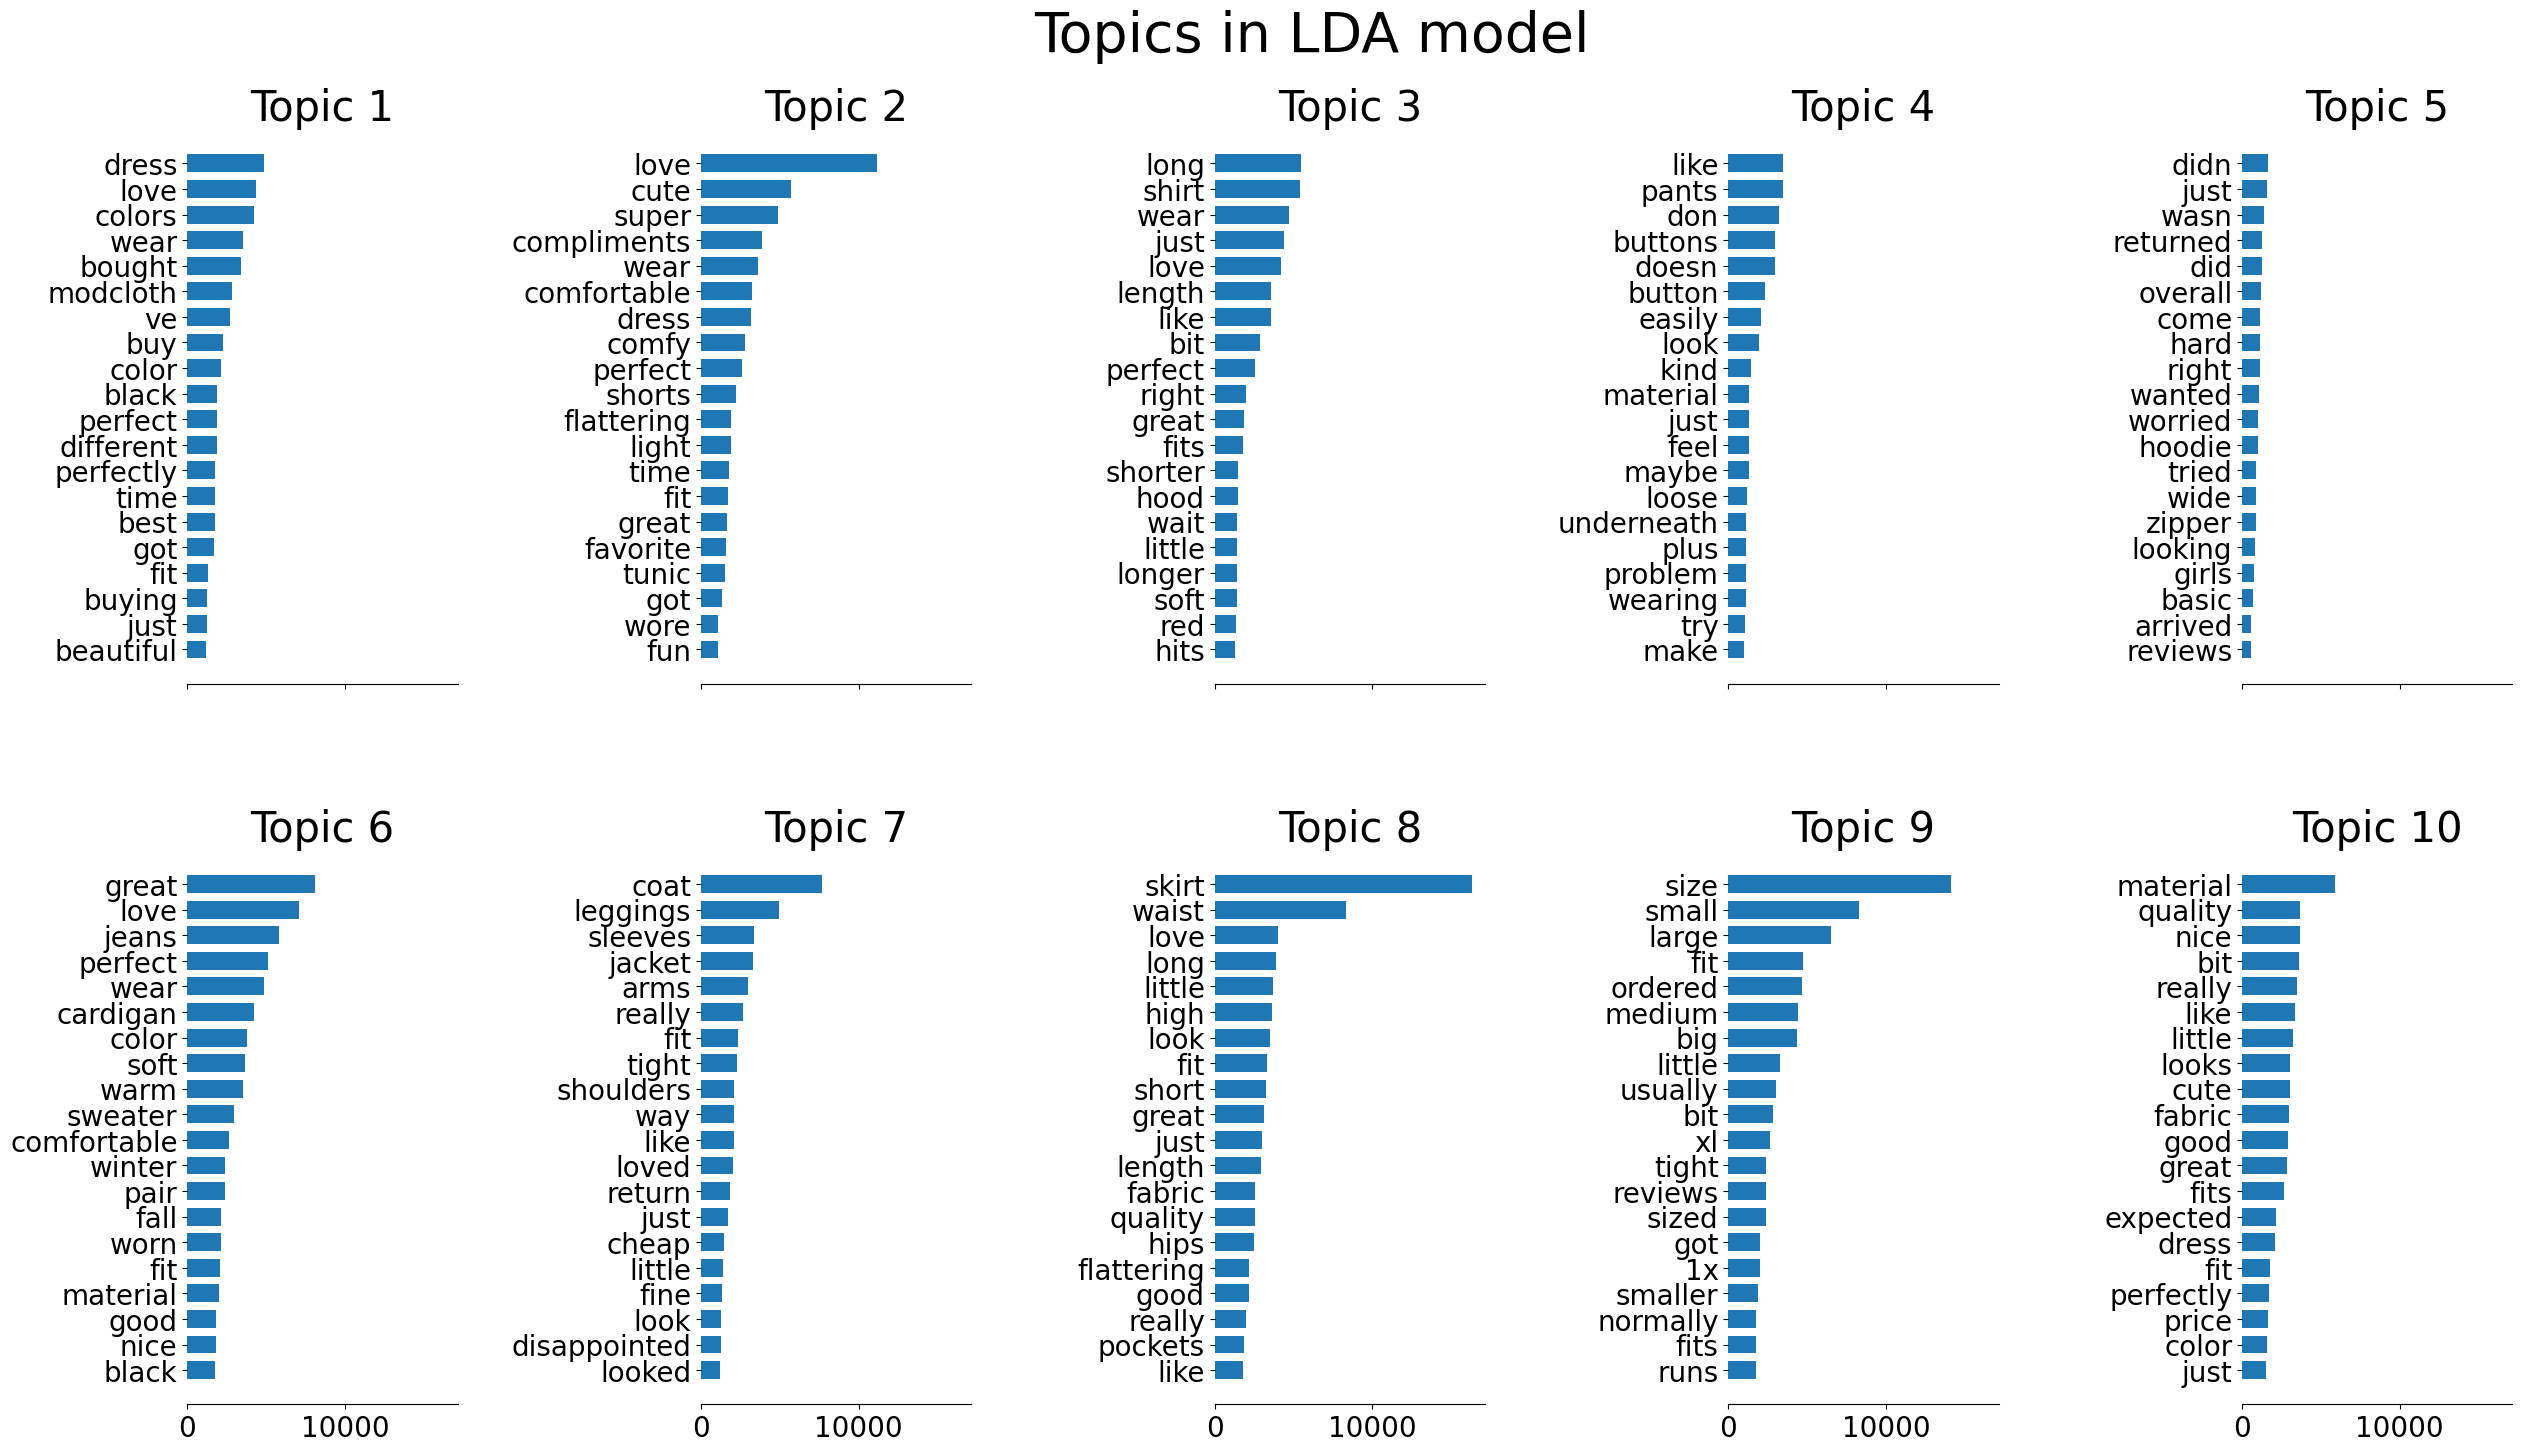

In [46]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(corpus)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(corpus)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# t-SNE and Manifold Learning

Remove the data points with missing data

In [61]:
no_missing_data = final_df.dropna()

Use t-SNE (https://scikit-
learn.org/stable/modules/manifold.html#t-sne) to embed the data points in a low dimensional
space. Look at the guide at https://distill.pub/2016/misread-tsne/ and vary the parameters,
including the perplexity

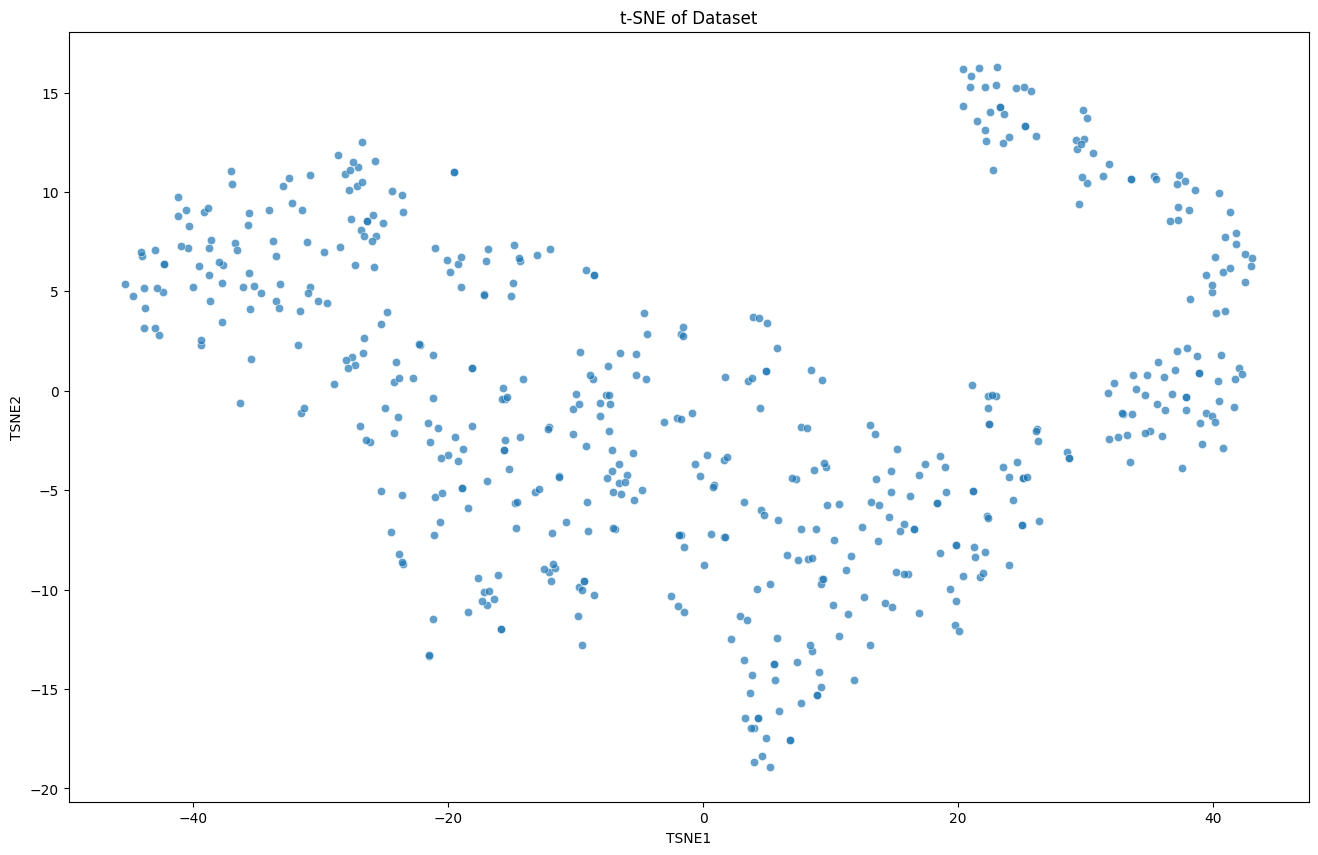

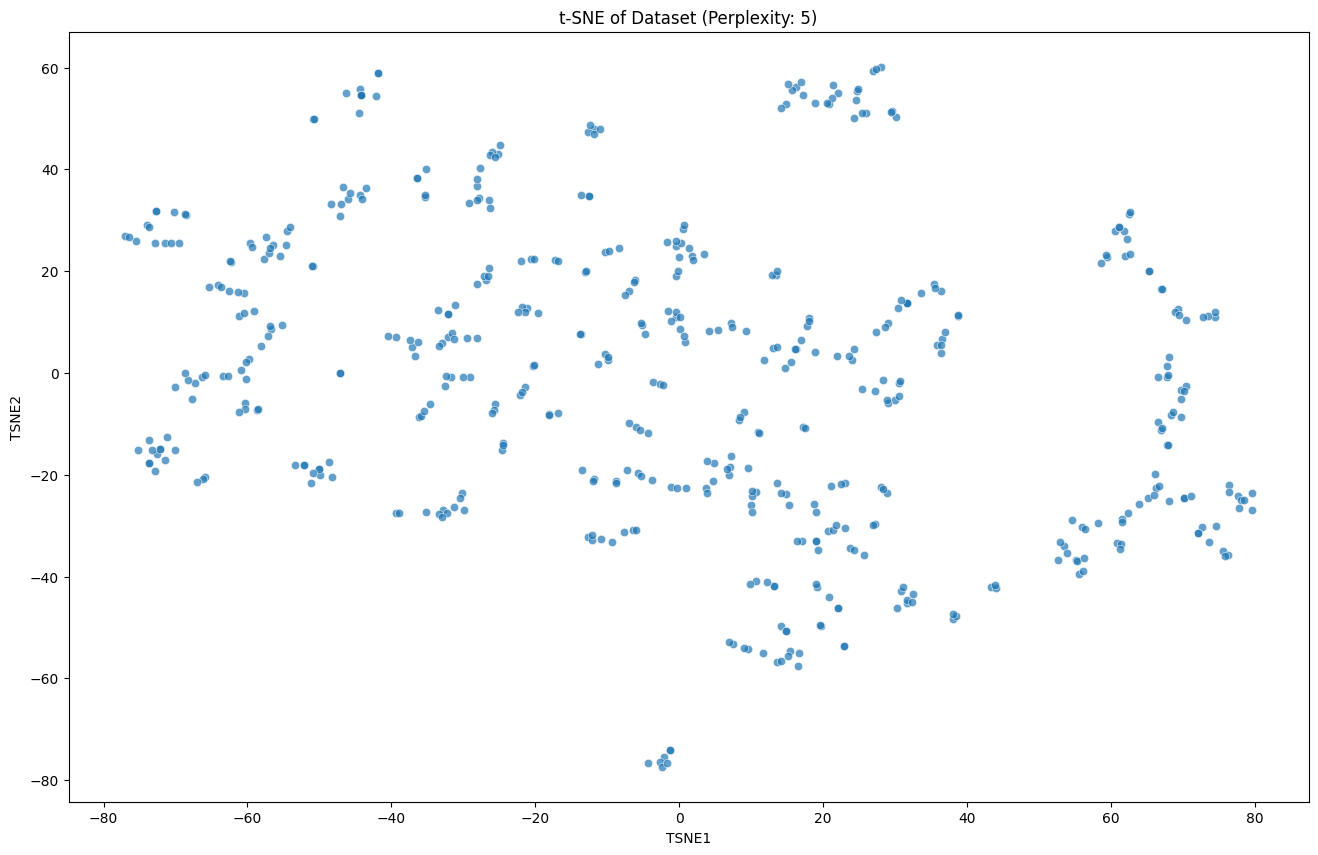

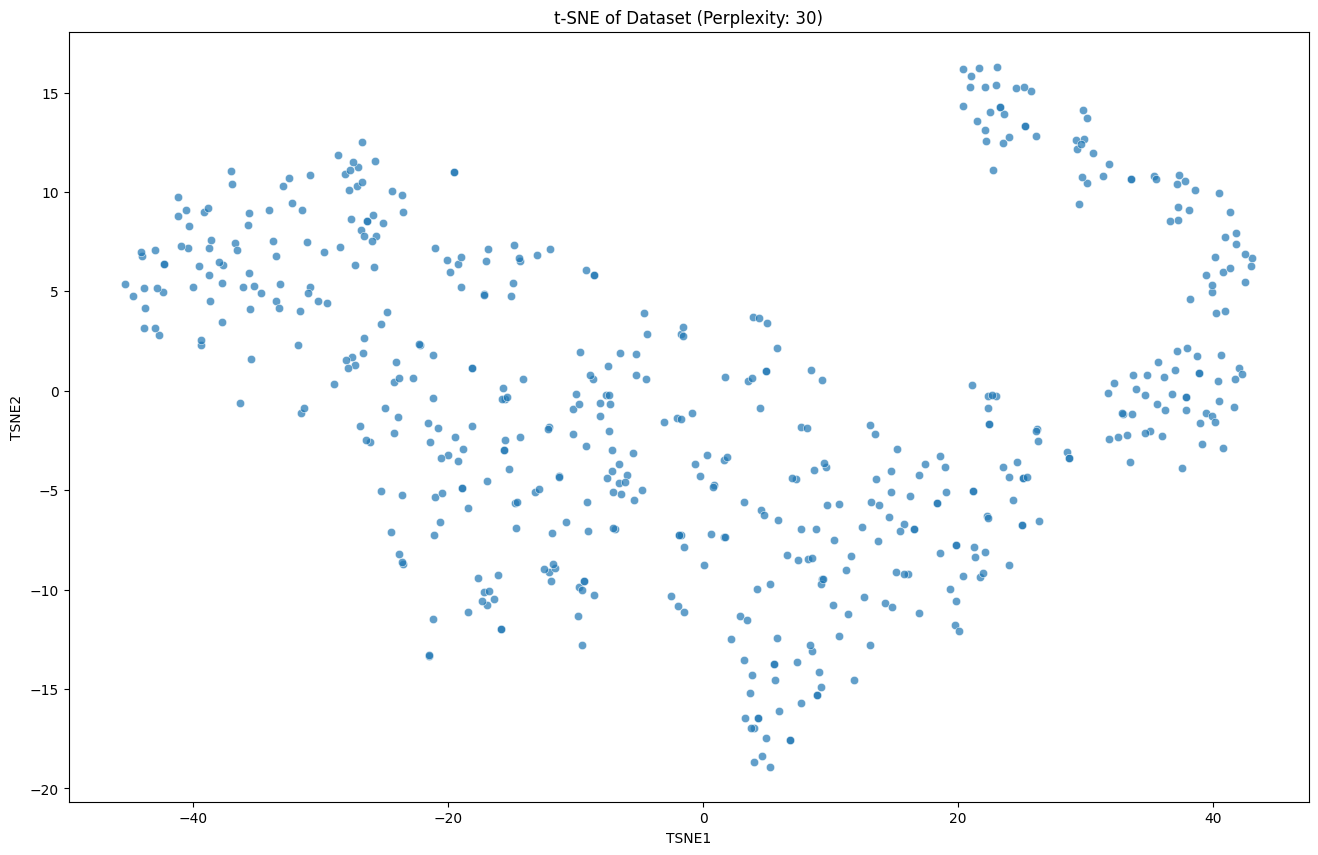

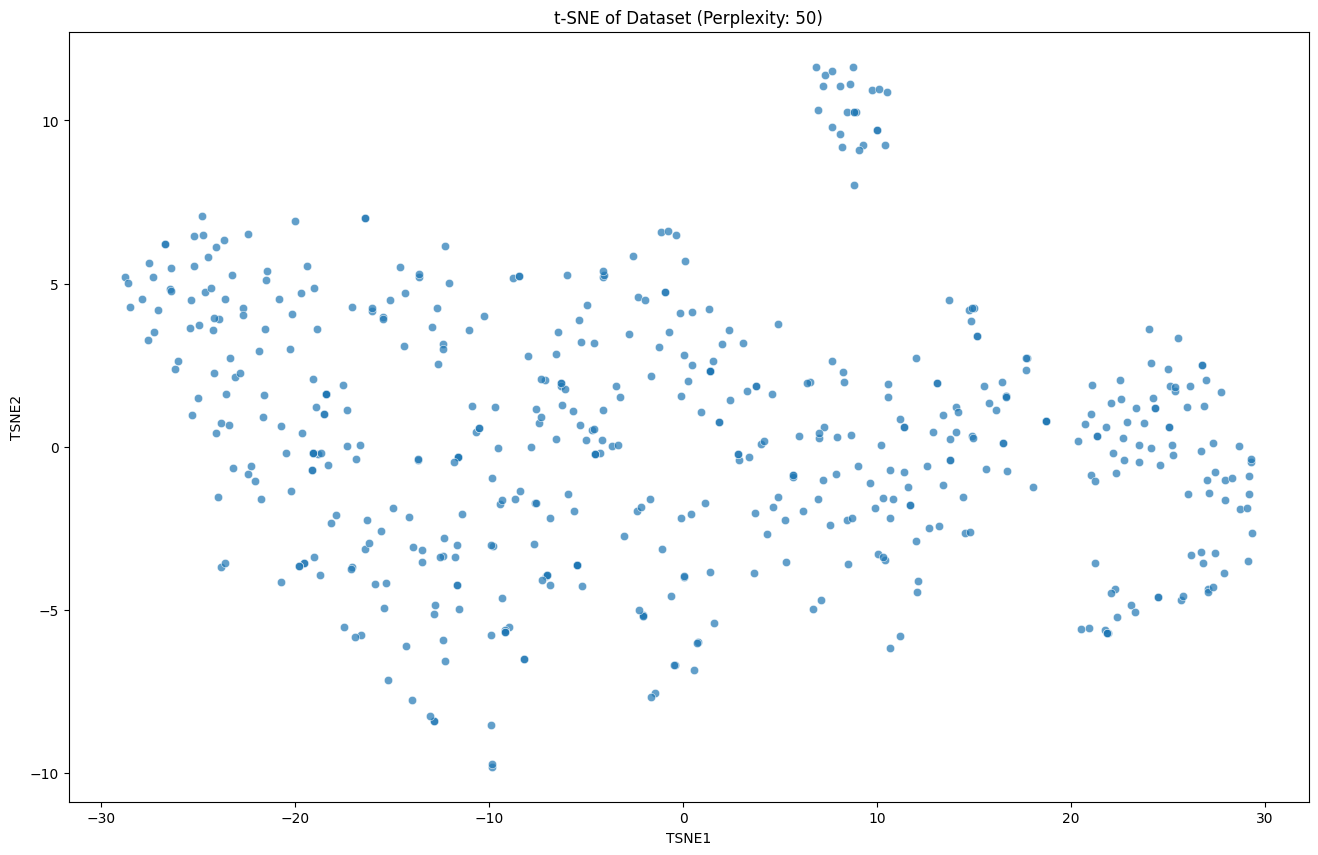

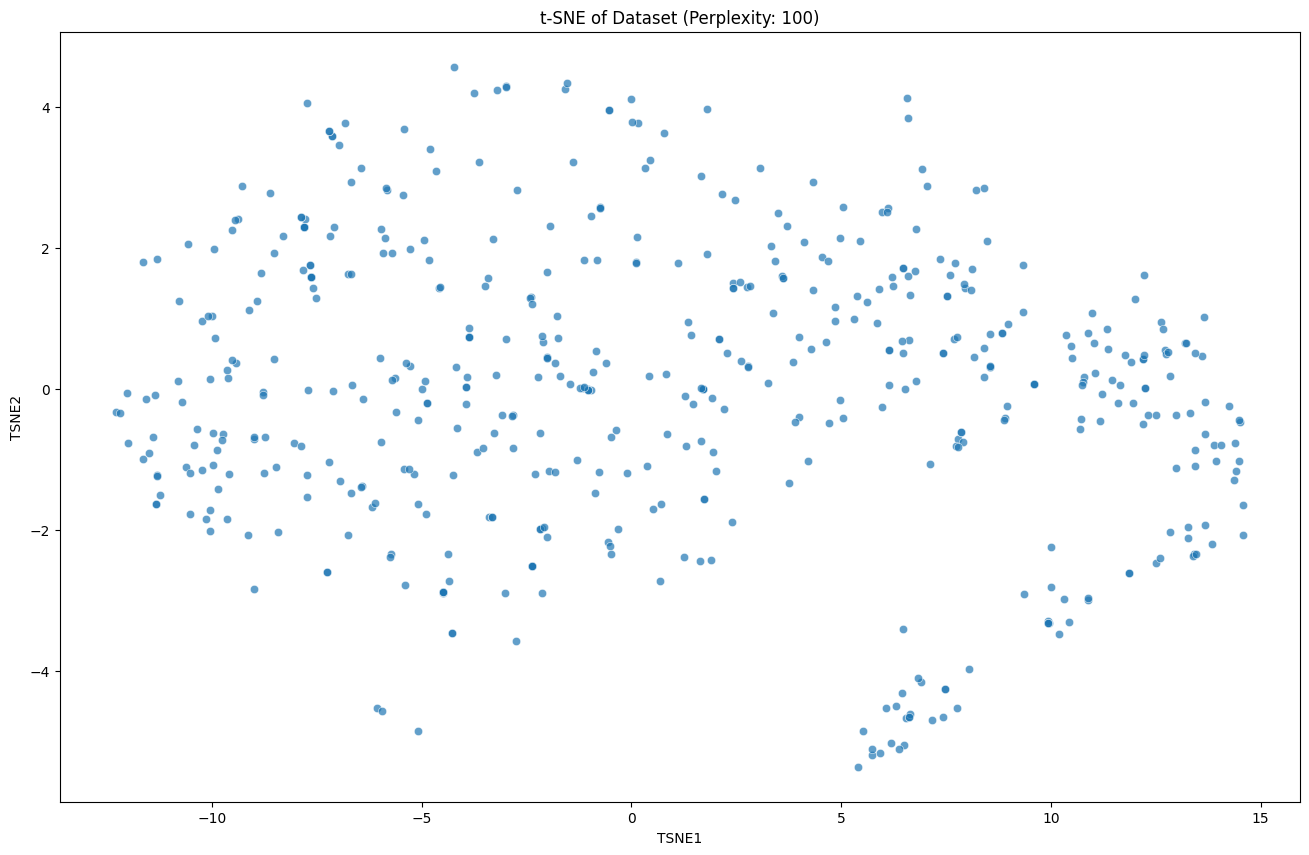

In [62]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(no_missing_data)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# Visualize the t-SNE results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE of Dataset')
plt.show()

# Experiment with different perplexity values
for perplexity in [5, 30, 50, 100]:
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(no_missing_data)

    # Create a DataFrame with t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

    # Visualize the t-SNE results
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        data=tsne_df,
        legend='full',
        alpha=0.7
    )
    plt.title(f't-SNE of Dataset (Perplexity: {perplexity})')
    plt.show()

When you have an embedding that looks good, label it using the columns of X, using seaborn’s
scatterplot and hue. Plot all the categorical and numerical variables.


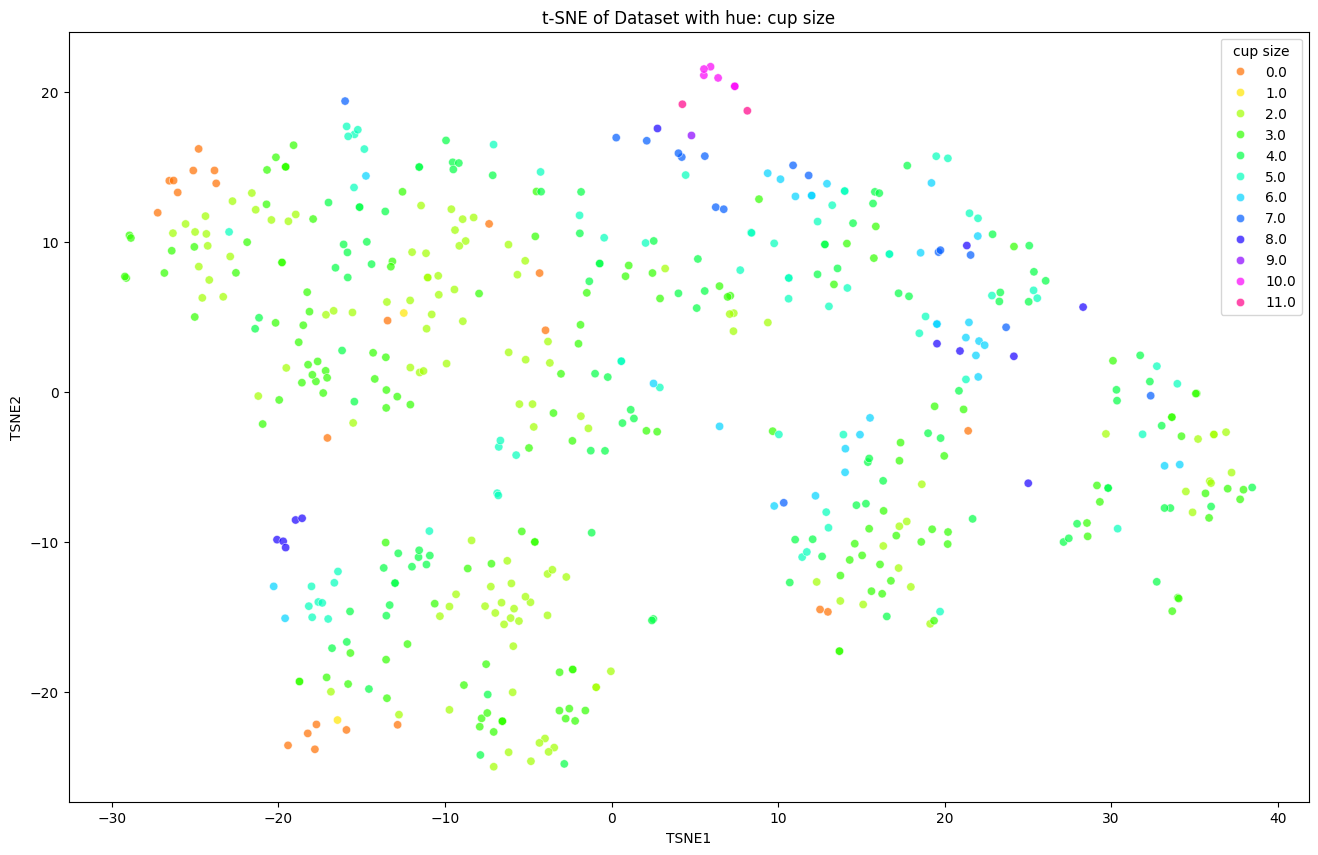

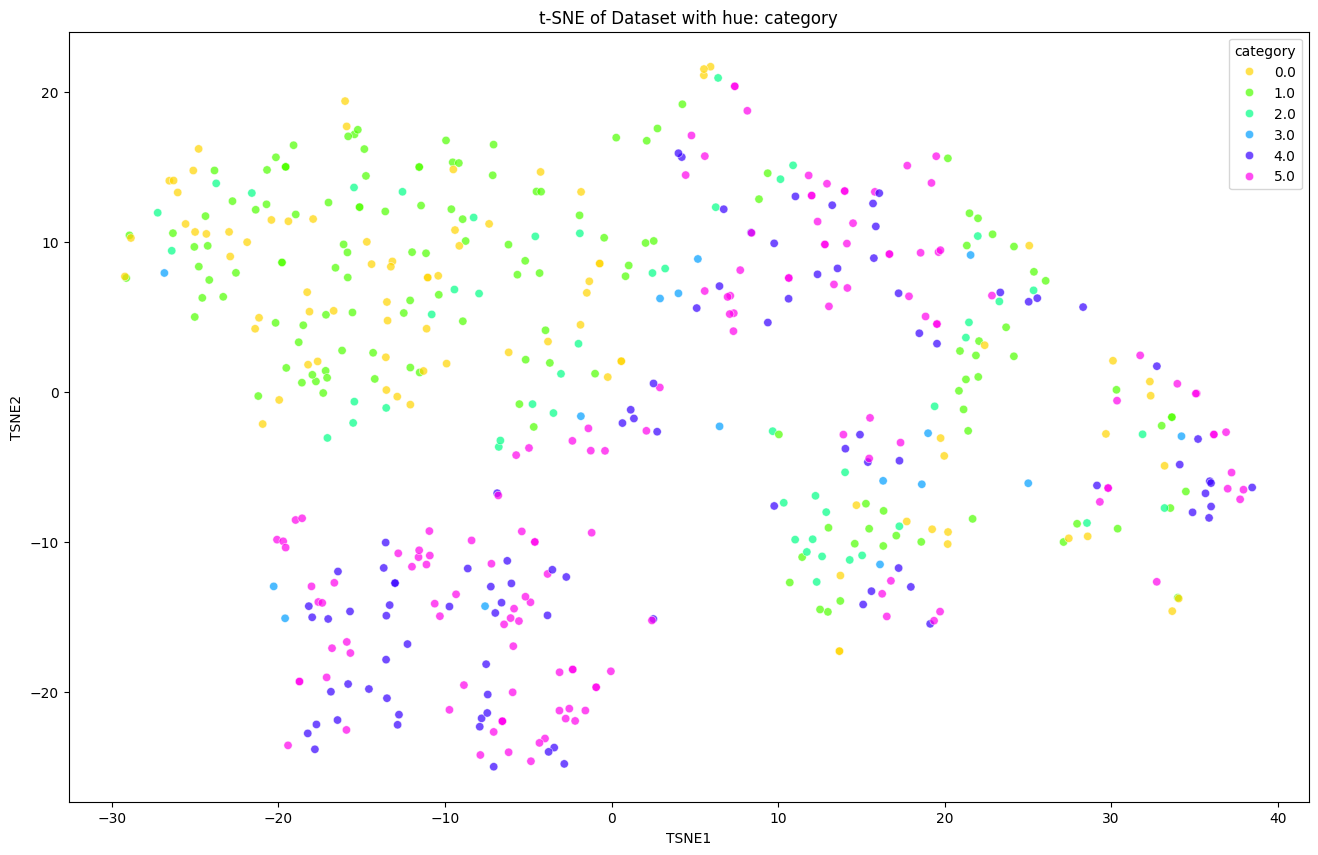

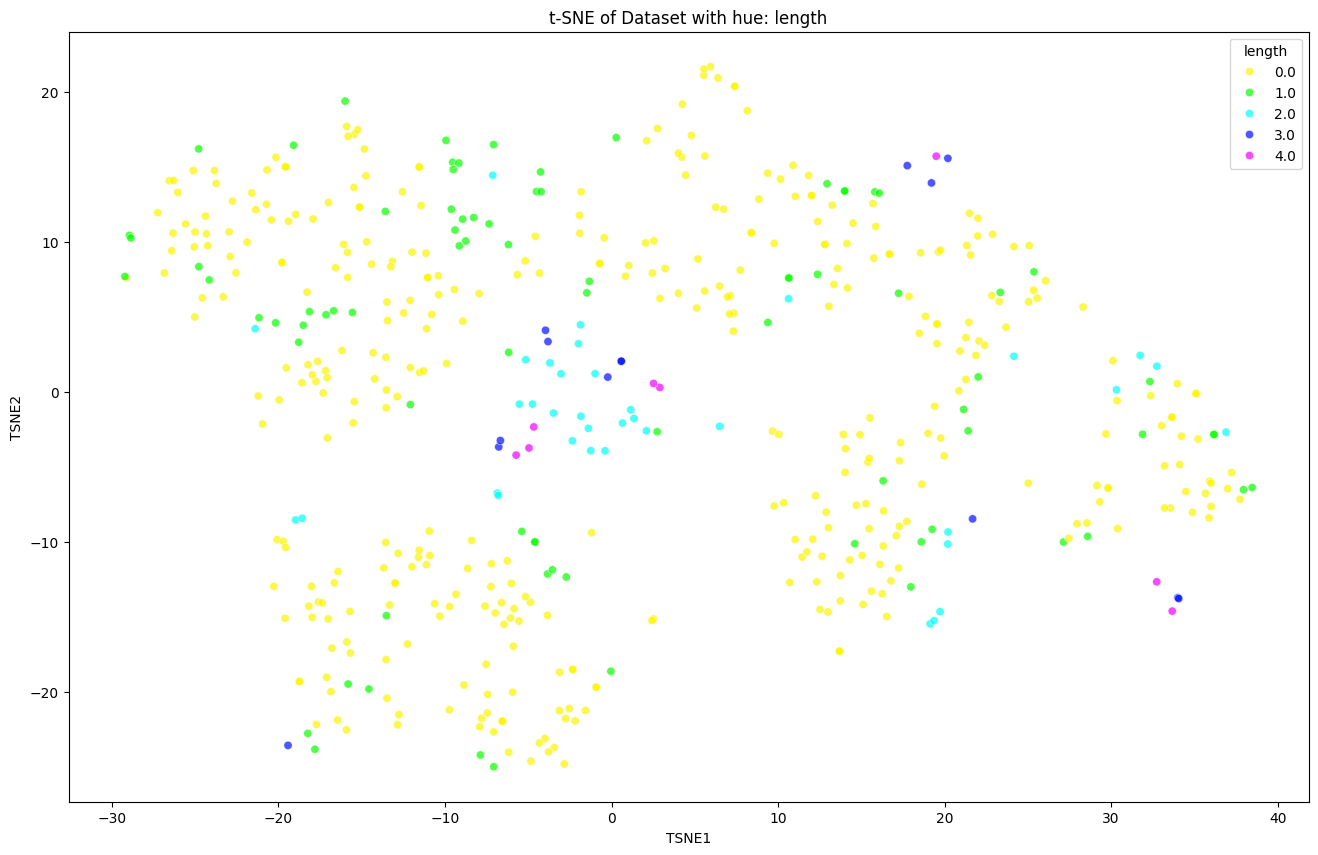

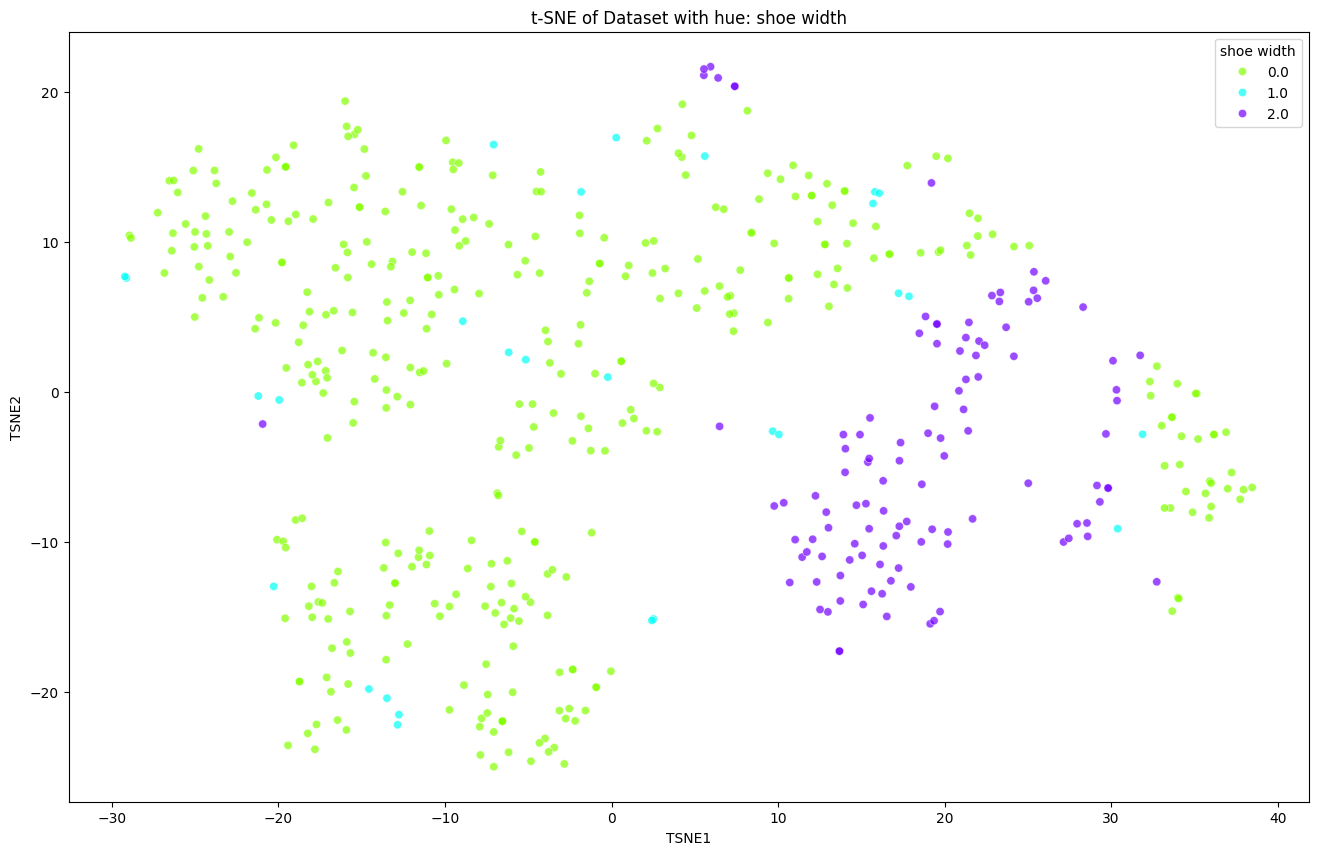

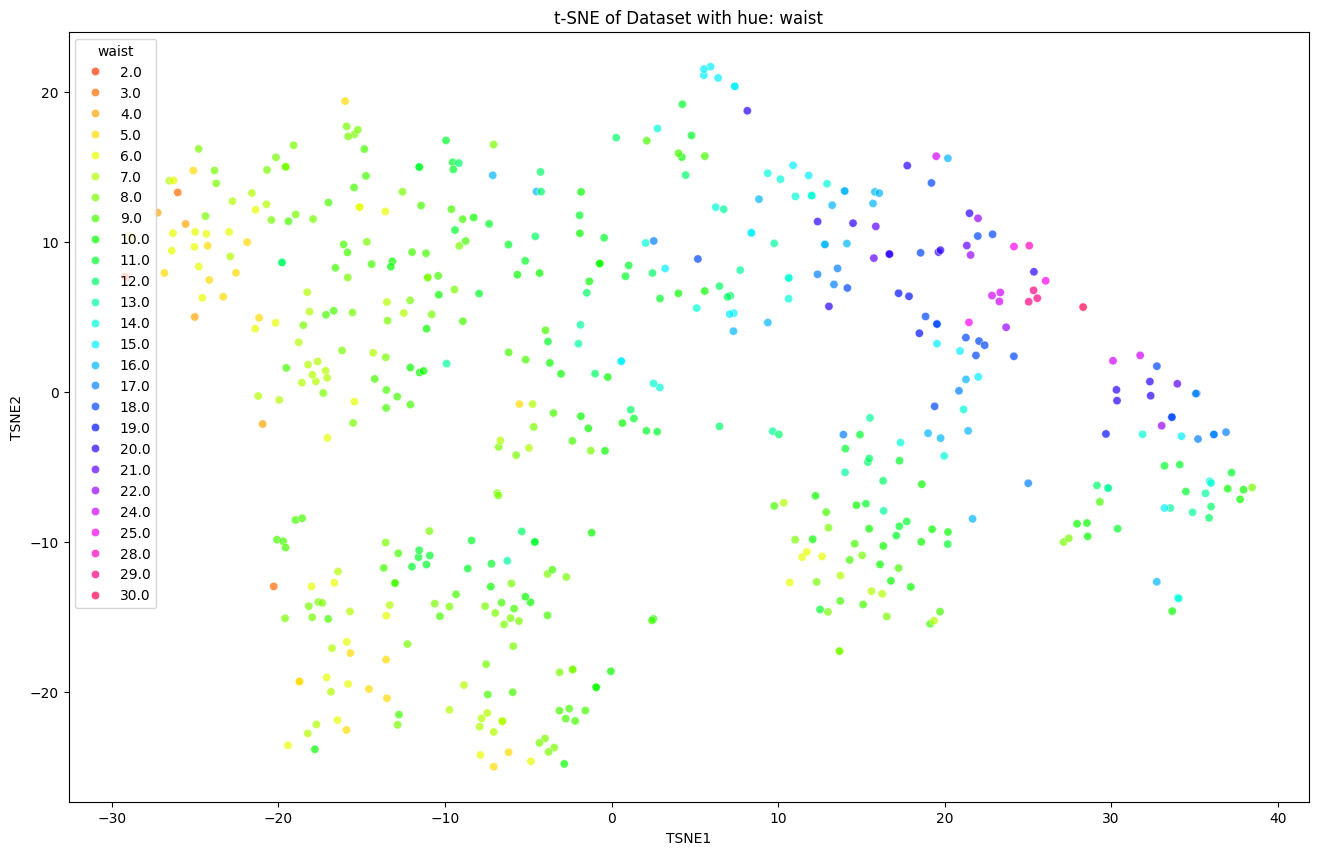

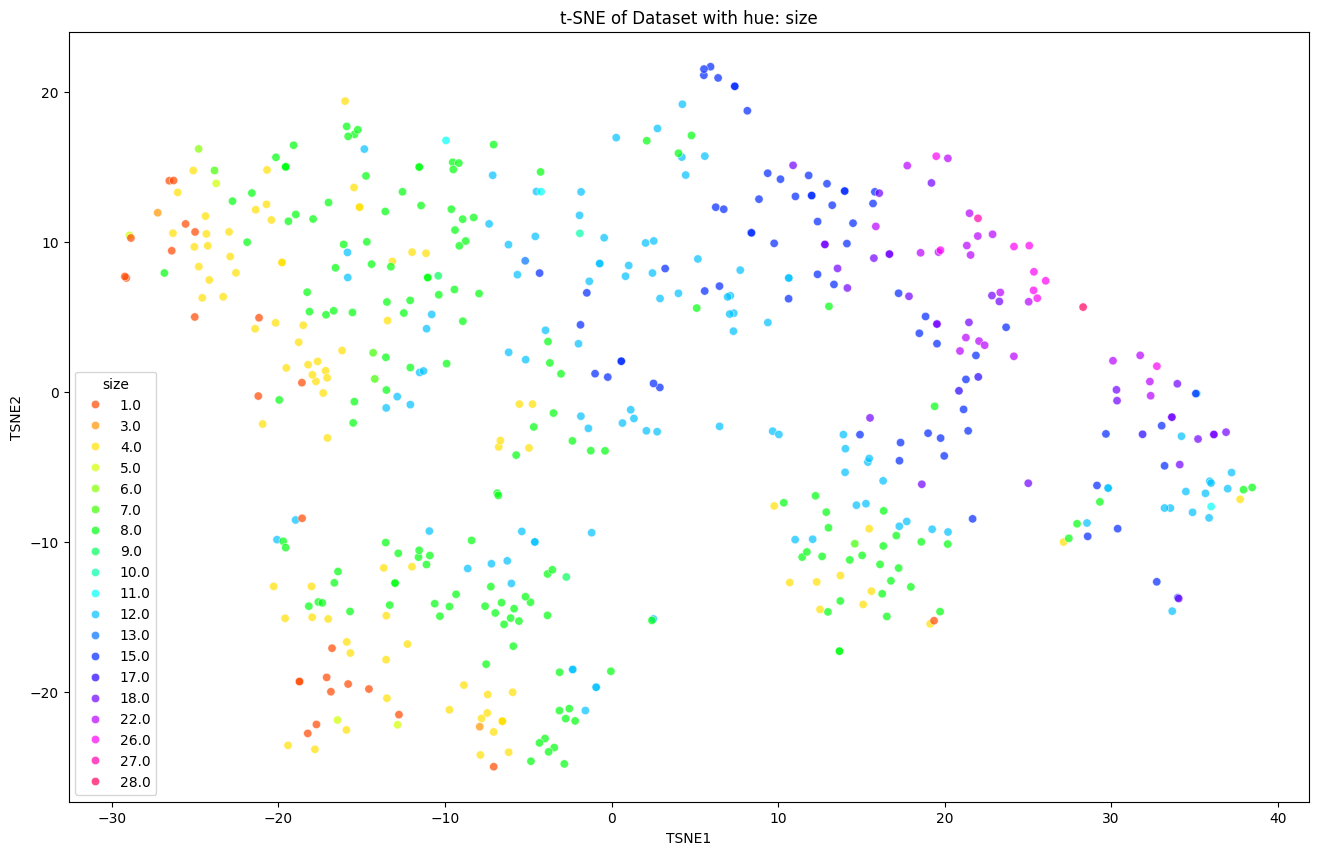

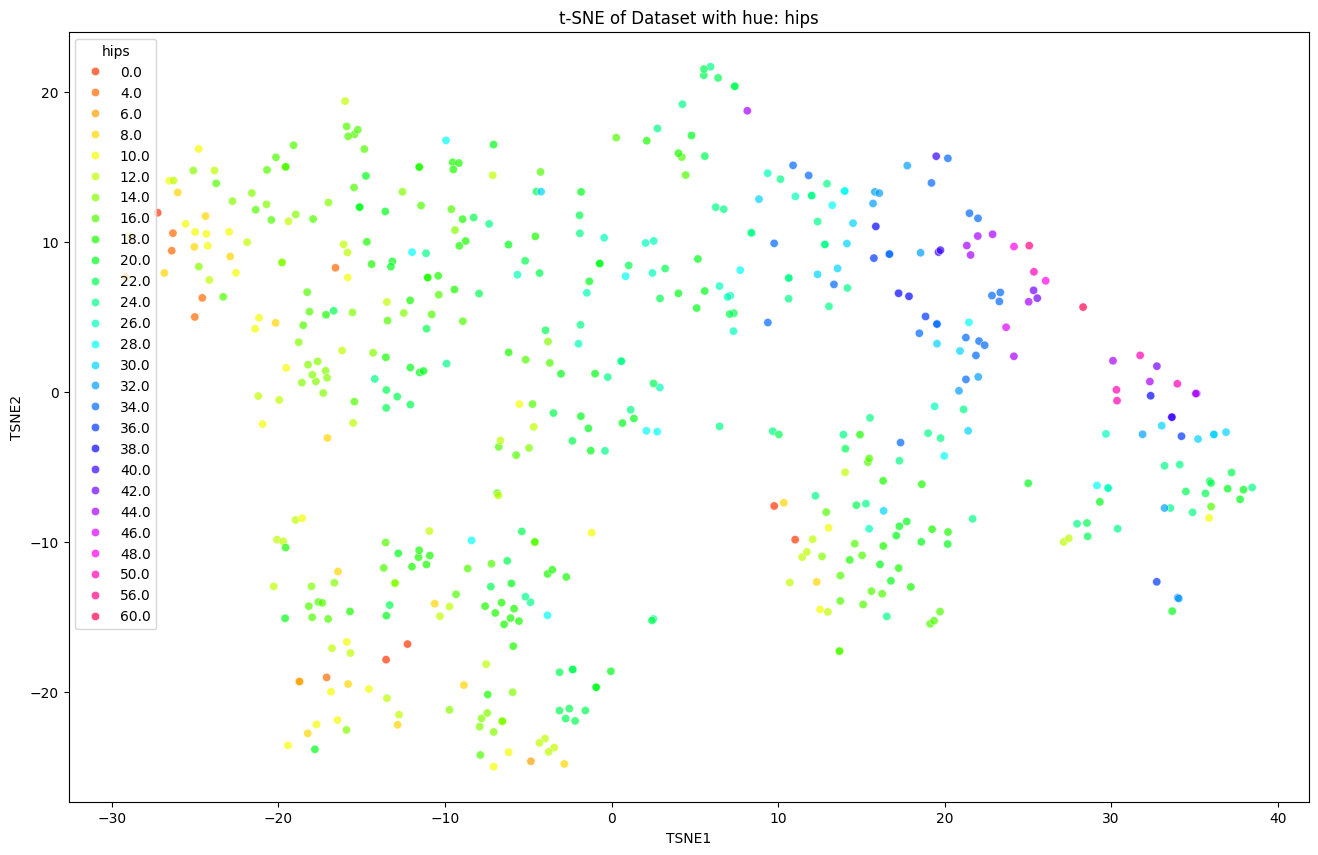

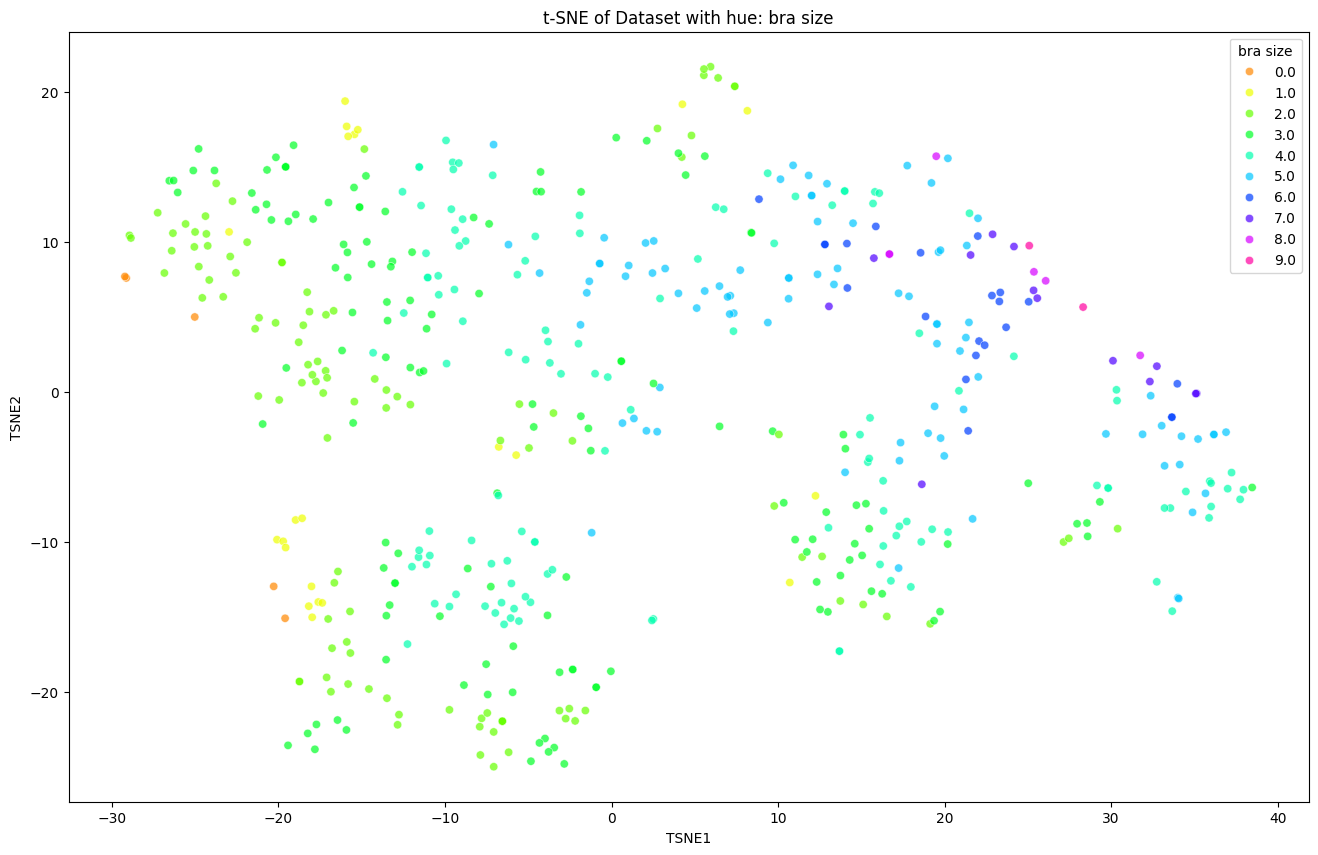

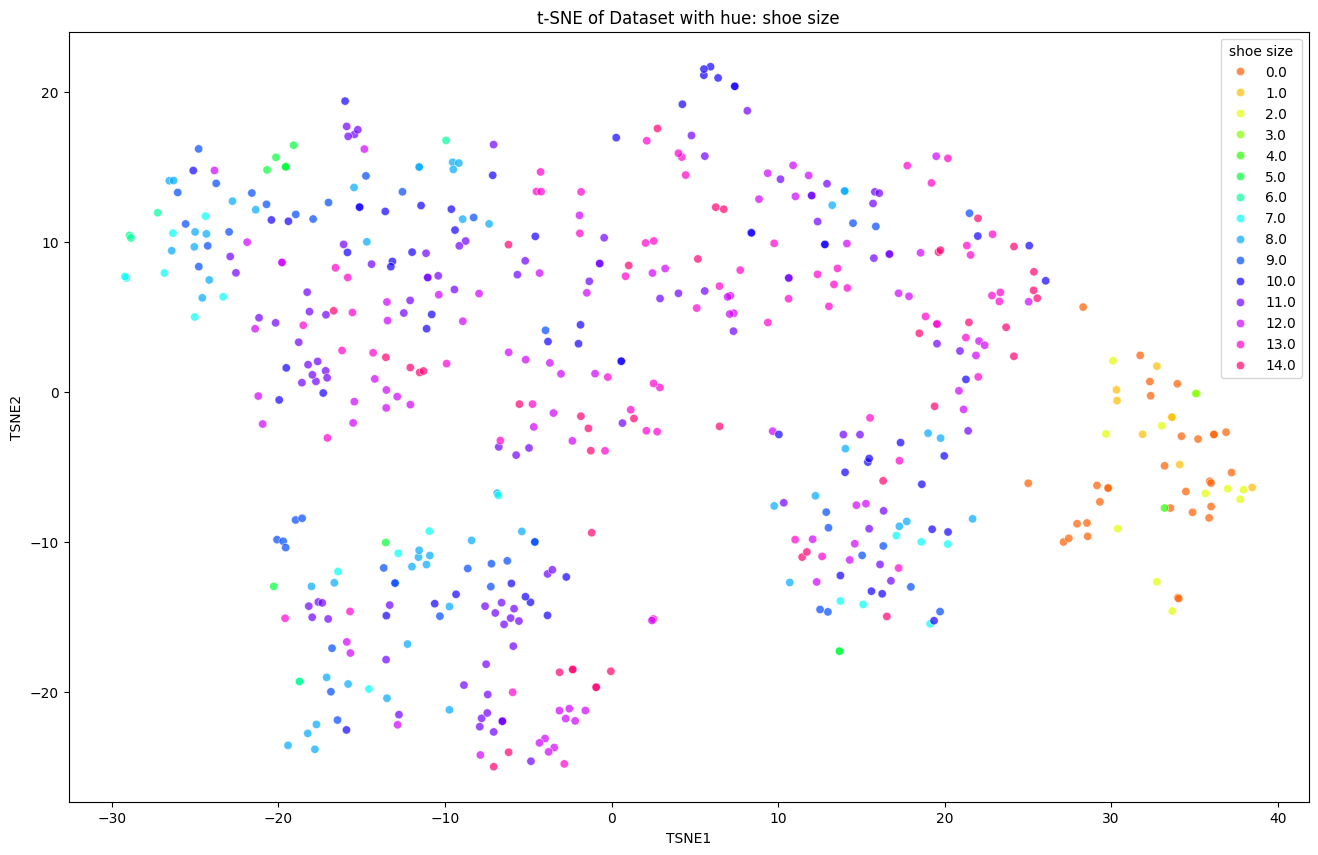

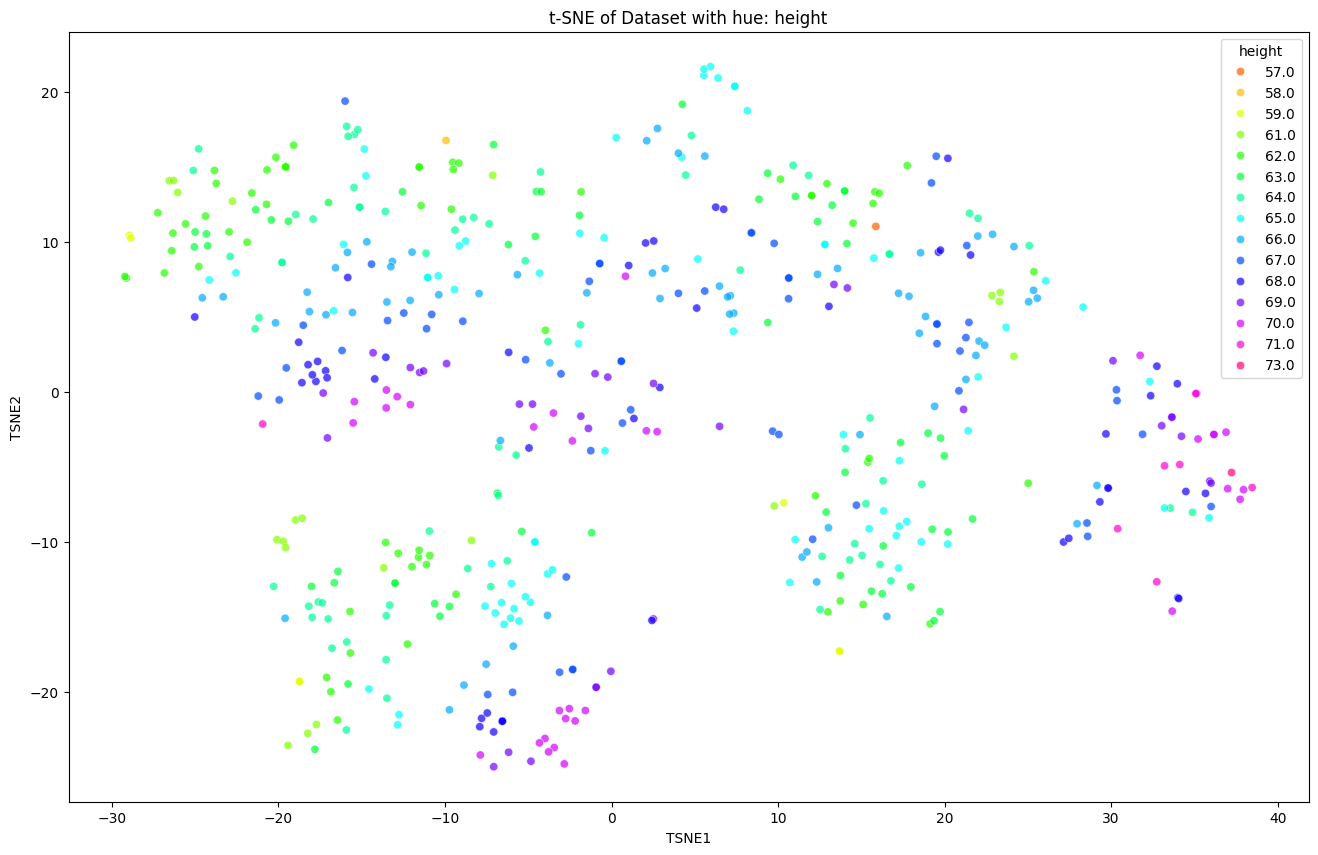

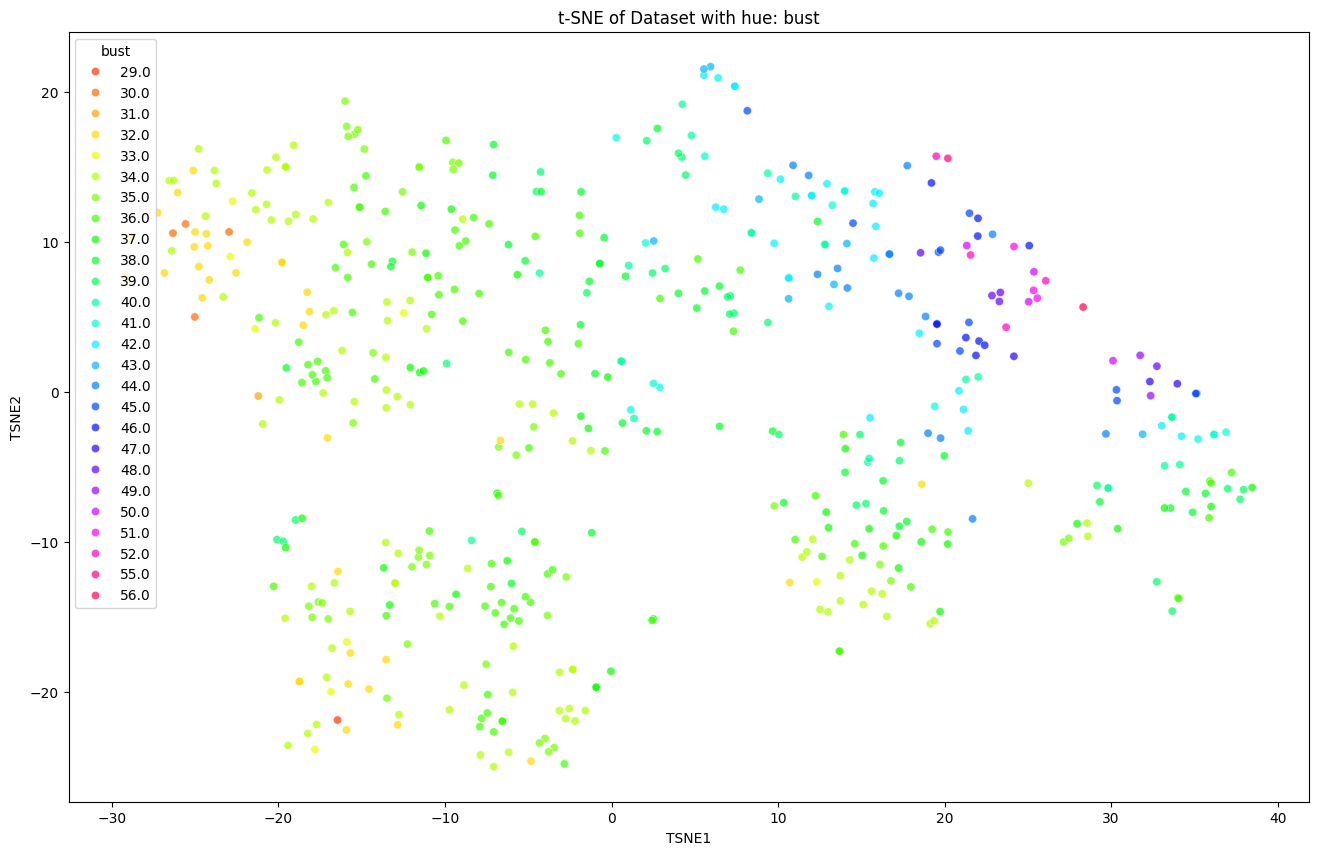

In [65]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(no_missing_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# Add the original data columns back to the t-SNE results for labeling
tsne_df = pd.concat([tsne_df, no_missing_data.reset_index(drop=True)], axis=1)

# Function to plot t-SNE results with hue based on different columns
def plot_tsne_with_hue(data, hue_column):
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue=hue_column,
        palette=sns.color_palette("hsv", len(data[hue_column].unique())),
        data=data,
        legend='full',
        alpha=0.7
    )
    plt.title(f't-SNE of Dataset with hue: {hue_column}')
    plt.show()

# Plot t-SNE with different hue columns (categorical and numerical)
categorical_columns = encoded_df.columns.tolist()
numerical_columns = numeric_df.columns.tolist()

# Plotting categorical variables
for col in categorical_columns:
    plot_tsne_with_hue(tsne_df, col)

# Plotting numerical variables
for col in numerical_columns:
    plot_tsne_with_hue(tsne_df, col)
